## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## UCFMT Strain Tracking

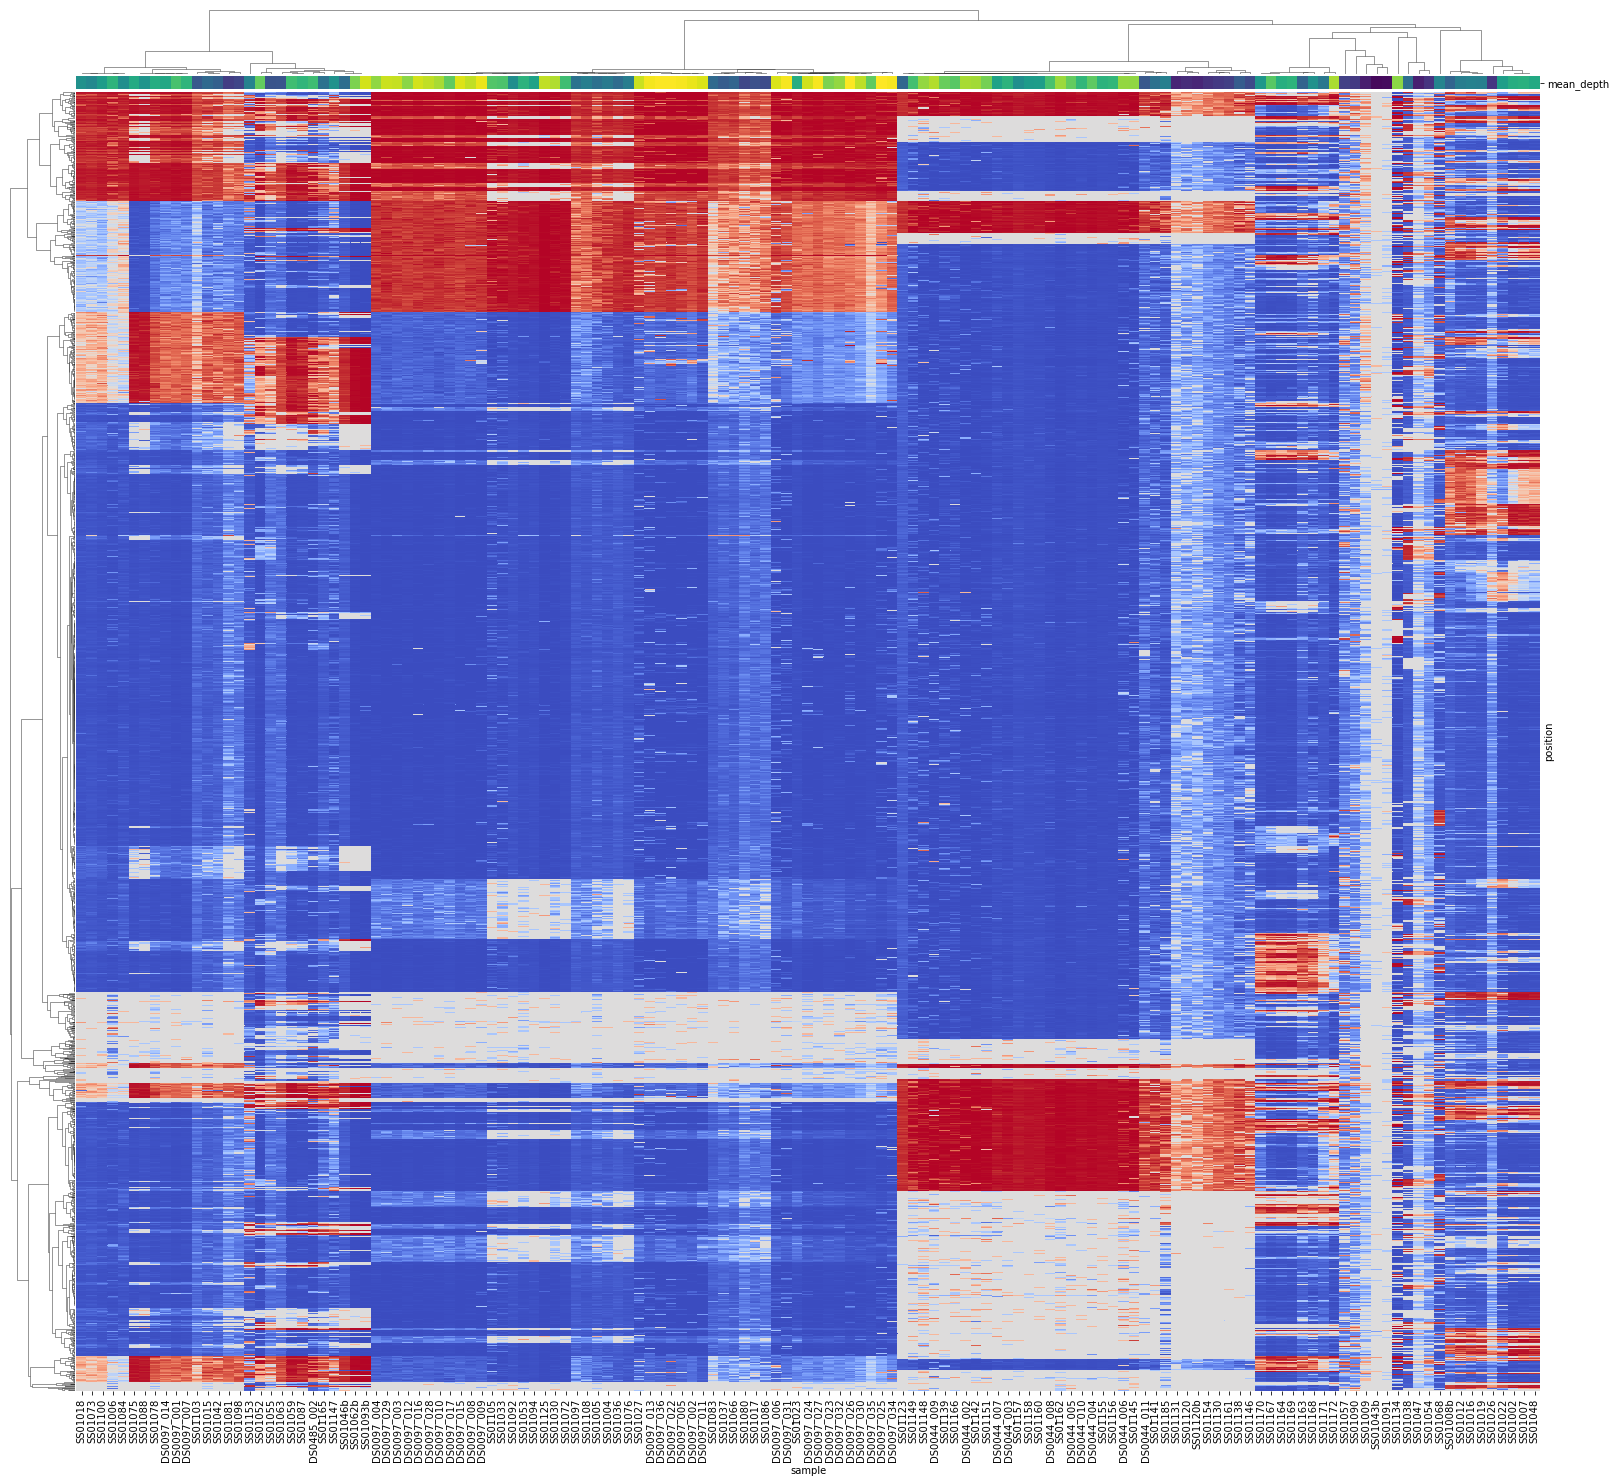

In [634]:
sf.plot.plot_metagenotype(
    mgen_ucfmt_100022.to_world(),
    col_linkage_func=lambda w: w.metagenotypes.linkage("sample"),
)

In [699]:
# fit_ucfmt_100022 = sf.data.World.load('data/ucfmt.sp-100022.metagenotype.filt-poly05-cvrg15-g2000.fit-sfacts8-s100-seed0.world.nc')
fit_ucfmt_100022 = sf.data.World.load('data/ucfmt.sp-100022.metagenotype.filt-poly05-cvrg05-g2000.fit-sfacts12-s100-g2000-seed0.world.nc')


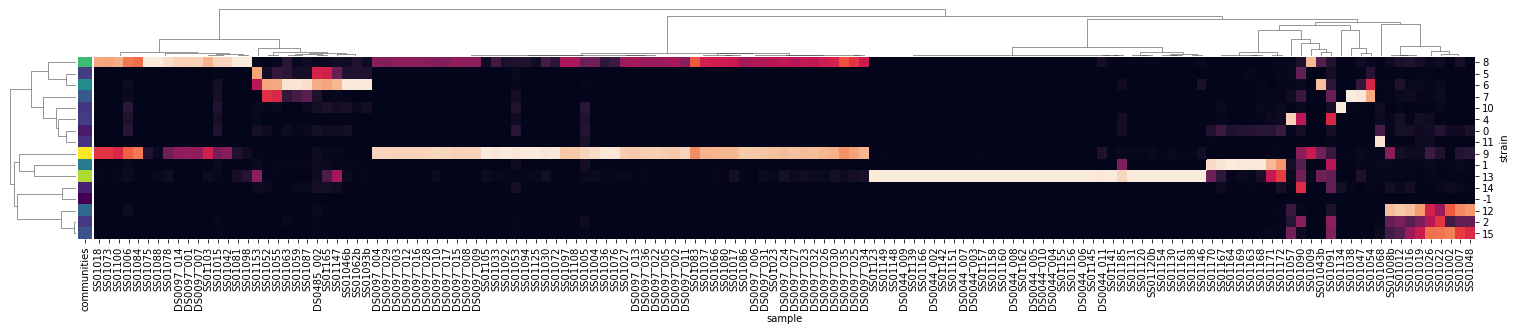

In [700]:
sf.plot.plot_community(
    fit_ucfmt_100022,
    col_linkage_func=lambda w: w.metagenotypes.linkage("sample"),
)

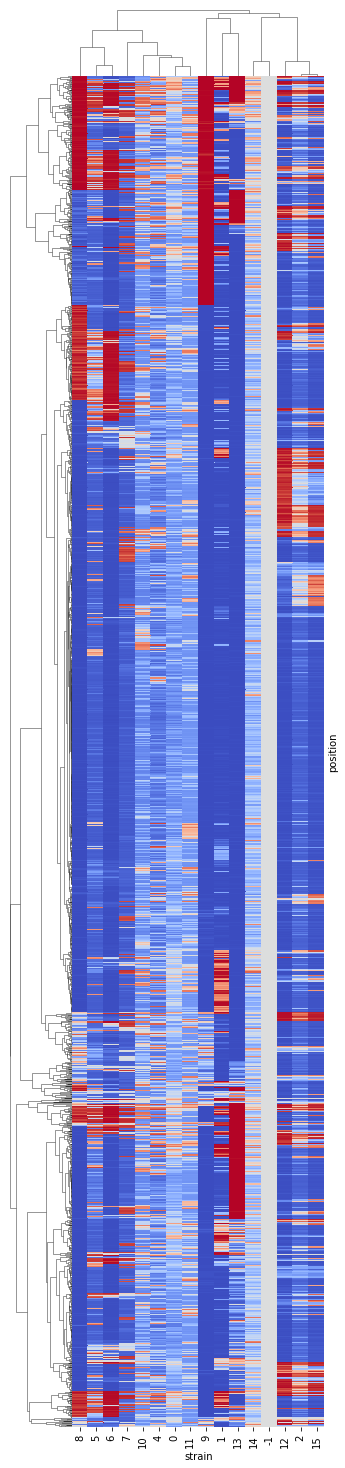

In [908]:
sf.plot.plot_genotype(
    fit_ucfmt_100022,
    col_linkage_func=lambda w: w.metagenotypes.linkage("position"),
    transpose=True,
)

sample   strain
SS01068  11        0.957966
         0         0.035870
         10        0.001976
         15        0.001543
         4         0.001201
         1         0.000399
         2         0.000201
Name: communities, dtype: float32

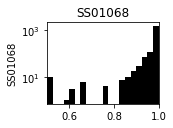

In [915]:
# sample = 'DS0485_002'
sample = 'SS01068'

sf.plot.plot_metagenotype_frequency_spectrum(fit_ucfmt_100022, sample_list=[sample])
plt.yscale('log')

fit_ucfmt_100022.data.sel(sample=[sample]).communities.to_series().sort_values(ascending=False).head(7)

## Single-cell genomics

In [5]:
mgen_ucfmt_104345 = sf.data.Metagenotypes.load('data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.nc')

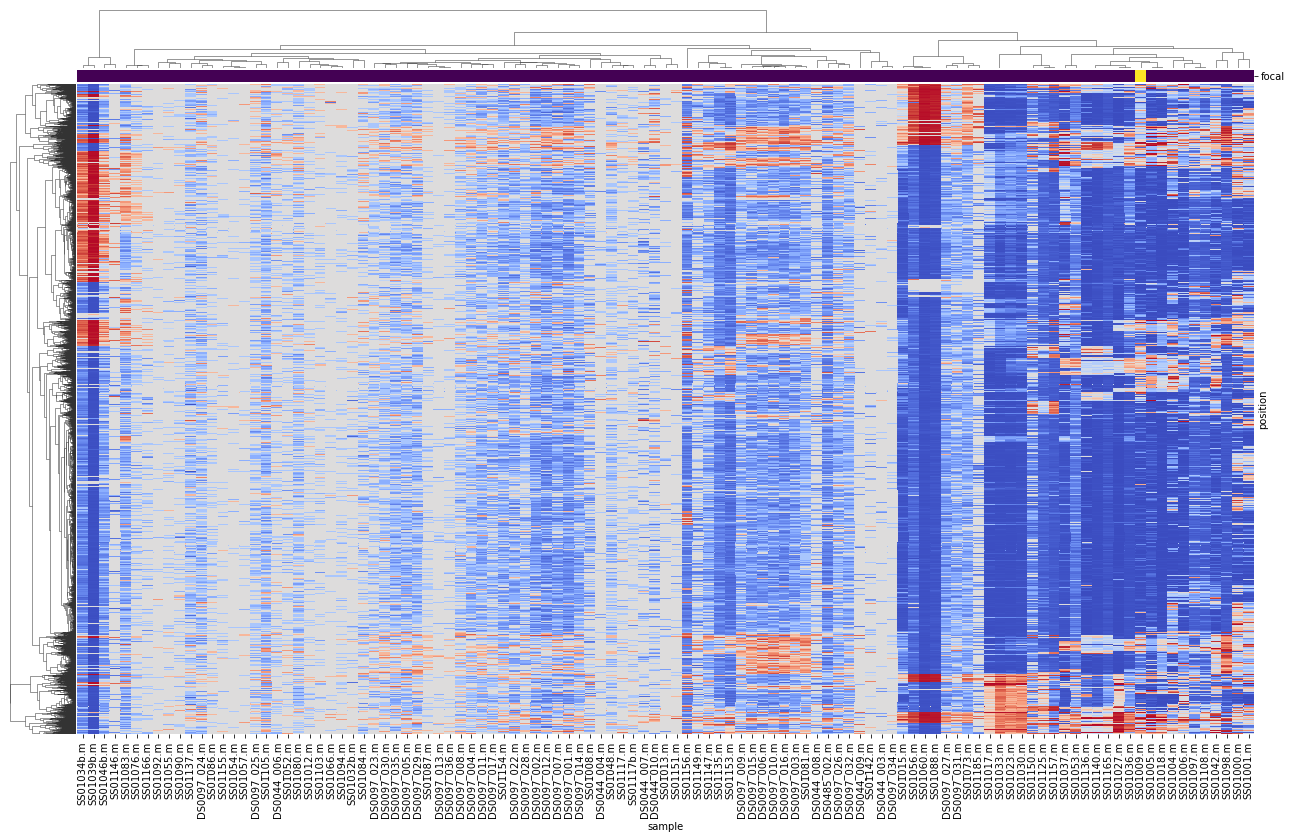

In [6]:
sf.plot.plot_metagenotype(
    mgen_ucfmt_104345.to_world(),
    col_linkage_func=lambda w: mgen_ucfmt_104345.linkage("sample"),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.isin(['SS01009.m']),
    )),
    scaley=1e-3 if mgen_ucfmt_104345.sizes['position'] > 1e2 else 1e-2
)

In [40]:
drplt_ucfmt_104345 = sf.data.Metagenotypes(
    sf.data.Metagenotypes.load('data/drplt.sp-104345.metagenotype.nc')
    .select_samples_with_coverage(0.01)
    .data.reindex(position=mgen_ucfmt_104345.position, fill_value=0)
)
drplt_ucfmt_104345_to_sample = pd.read_table('meta/drplt_to_sample.tsv')

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/plot.py:154: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/plot.py:154: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


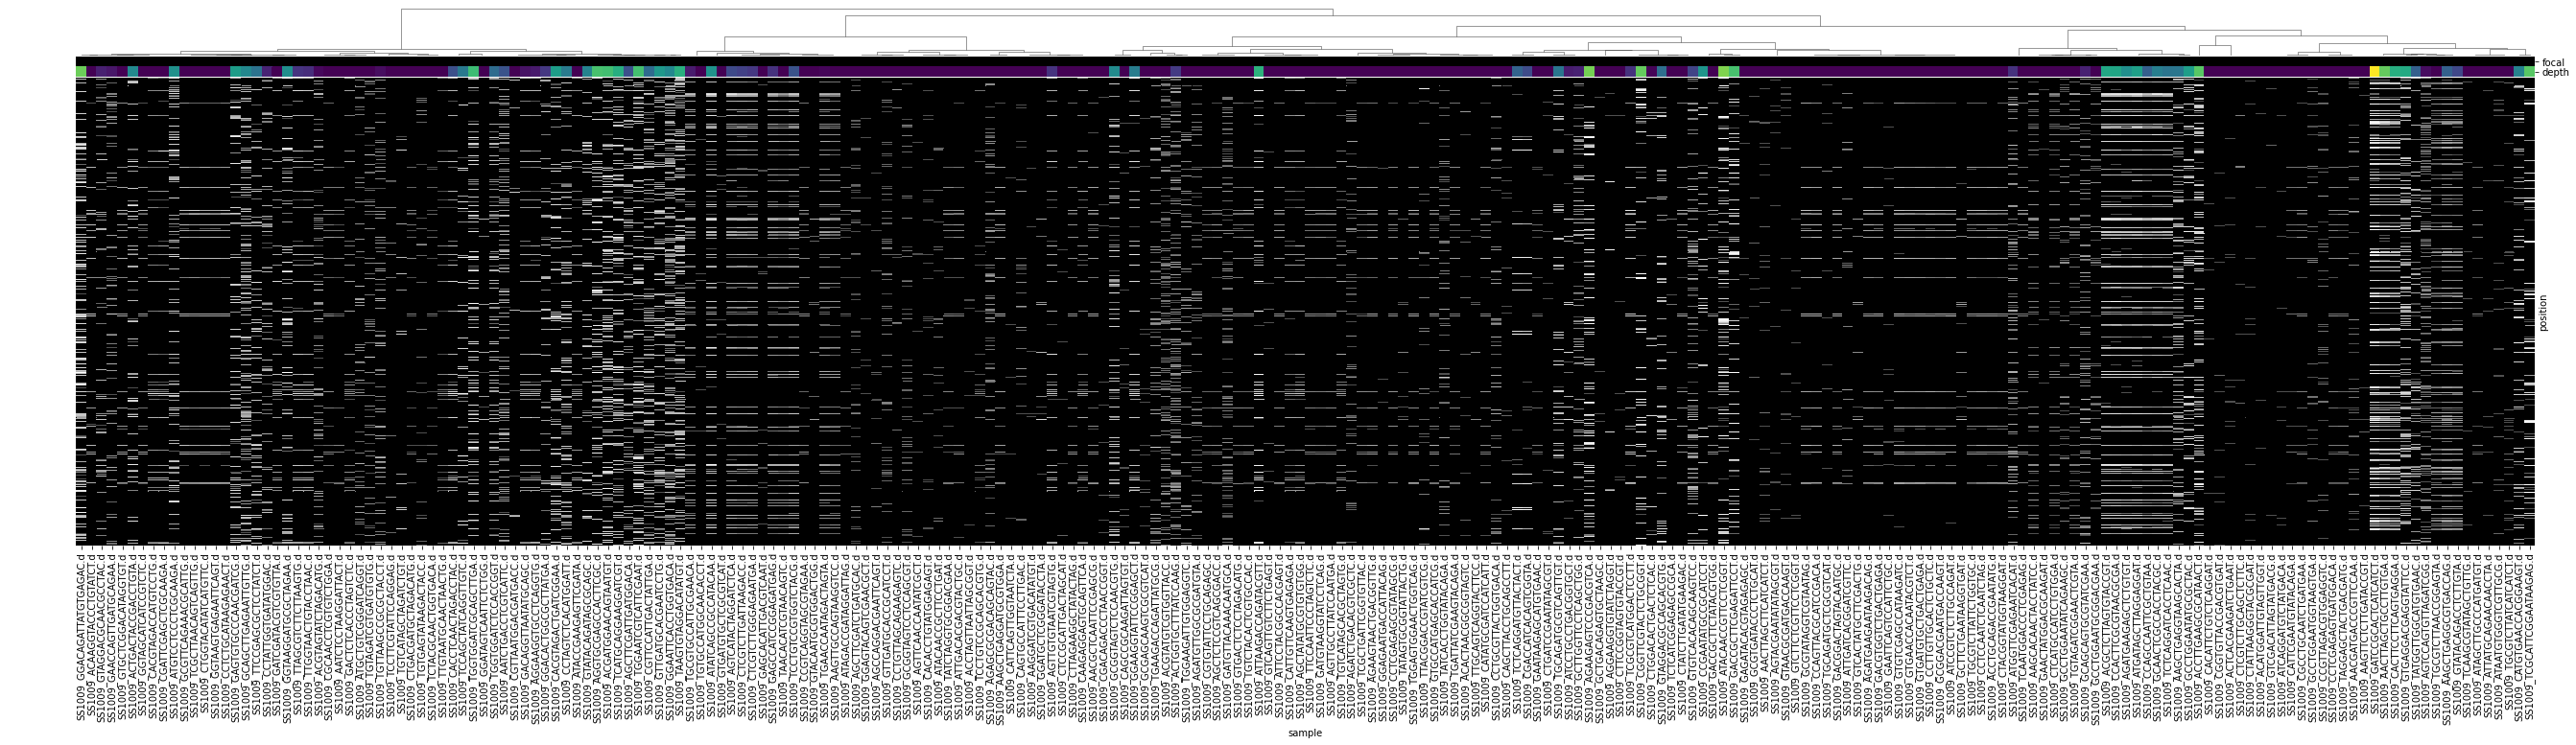

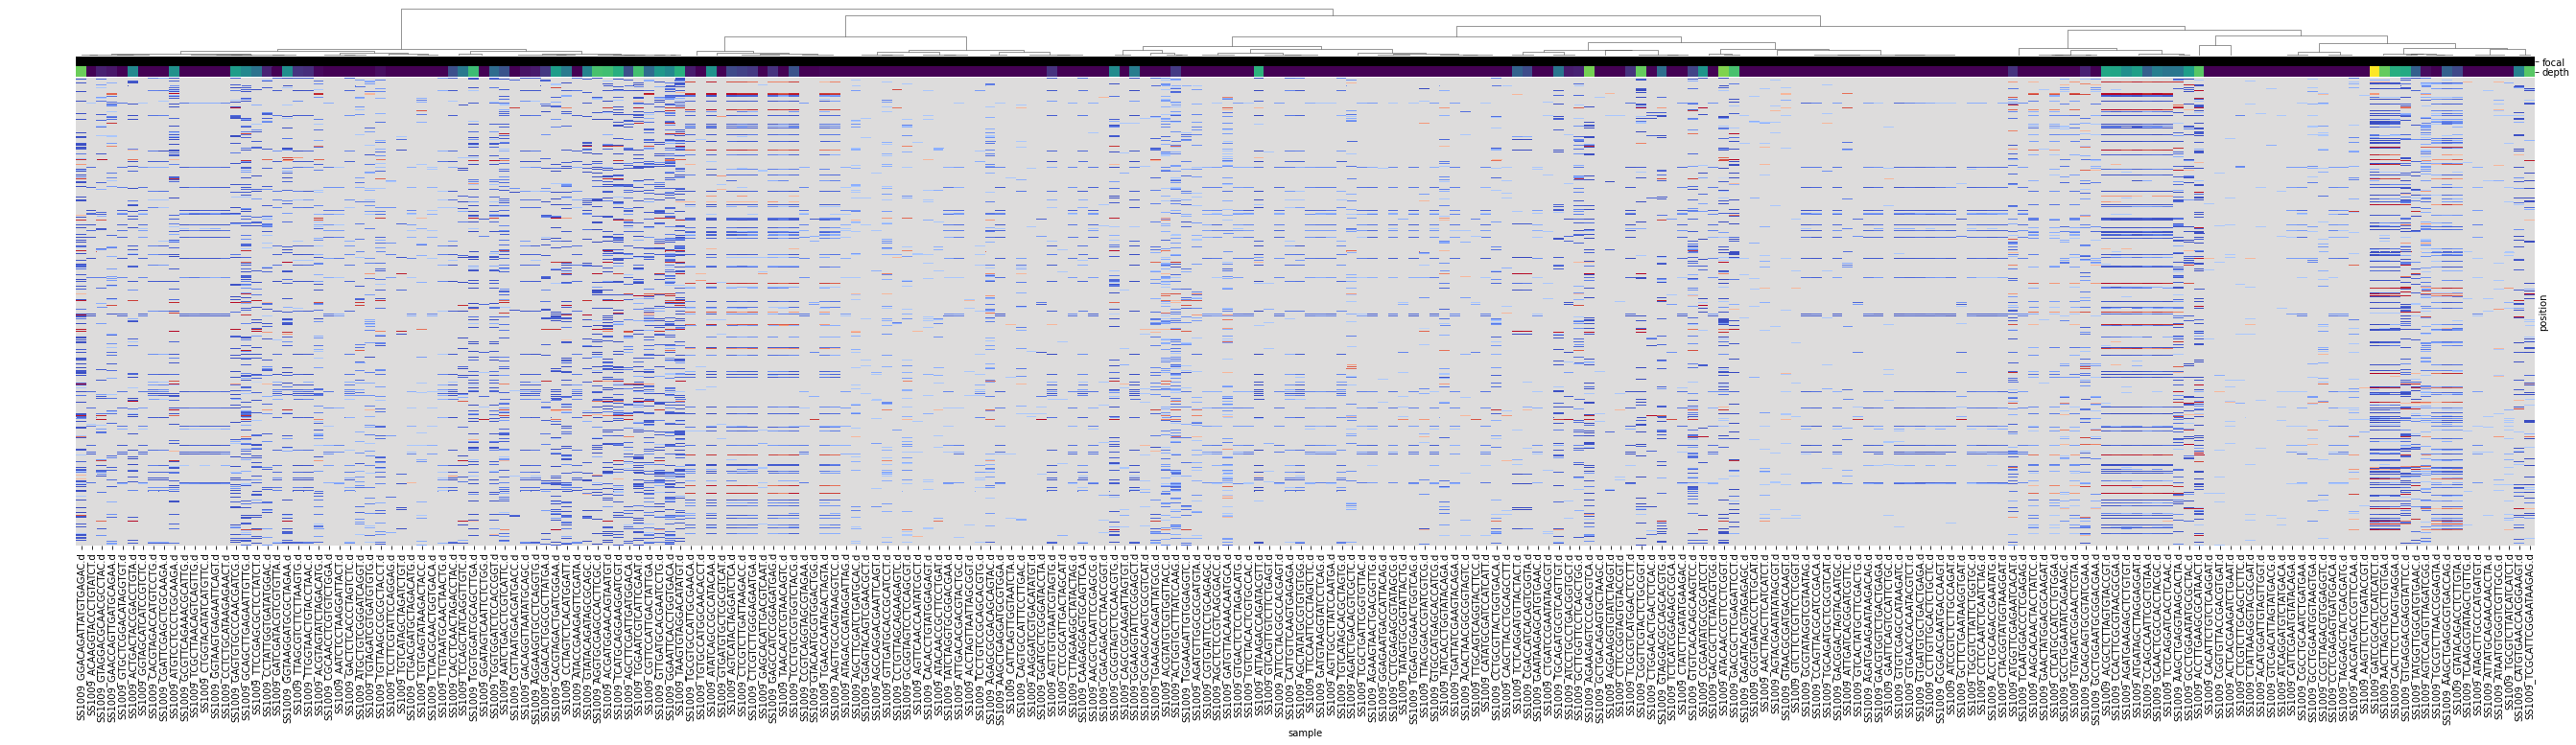

In [41]:
np.random.seed(0)

nposition = min(drplt_ucfmt_104345.sizes['position'], 1000)

d = drplt_ucfmt_104345.random_sample(position=nposition)

sf.plot.plot_depth(
    d.to_world(),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.isin(['mgen_SS01009.m', 'mgen_SS01057.m']),
        depth=w.metagenotypes.mean_depth().pipe(np.log),
#         mgen_entropy=w.metagenotypes.entropy('sample'),
    )),
)

sf.plot.plot_metagenotype(
    d.to_world(),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.isin(['mgen_SS01009.m', 'mgen_SS01057.m']),
        depth=w.metagenotypes.mean_depth().pipe(np.log),
#         mgen_entropy=w.metagenotypes.entropy('sample'),
    )),
)

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/plot.py:154: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


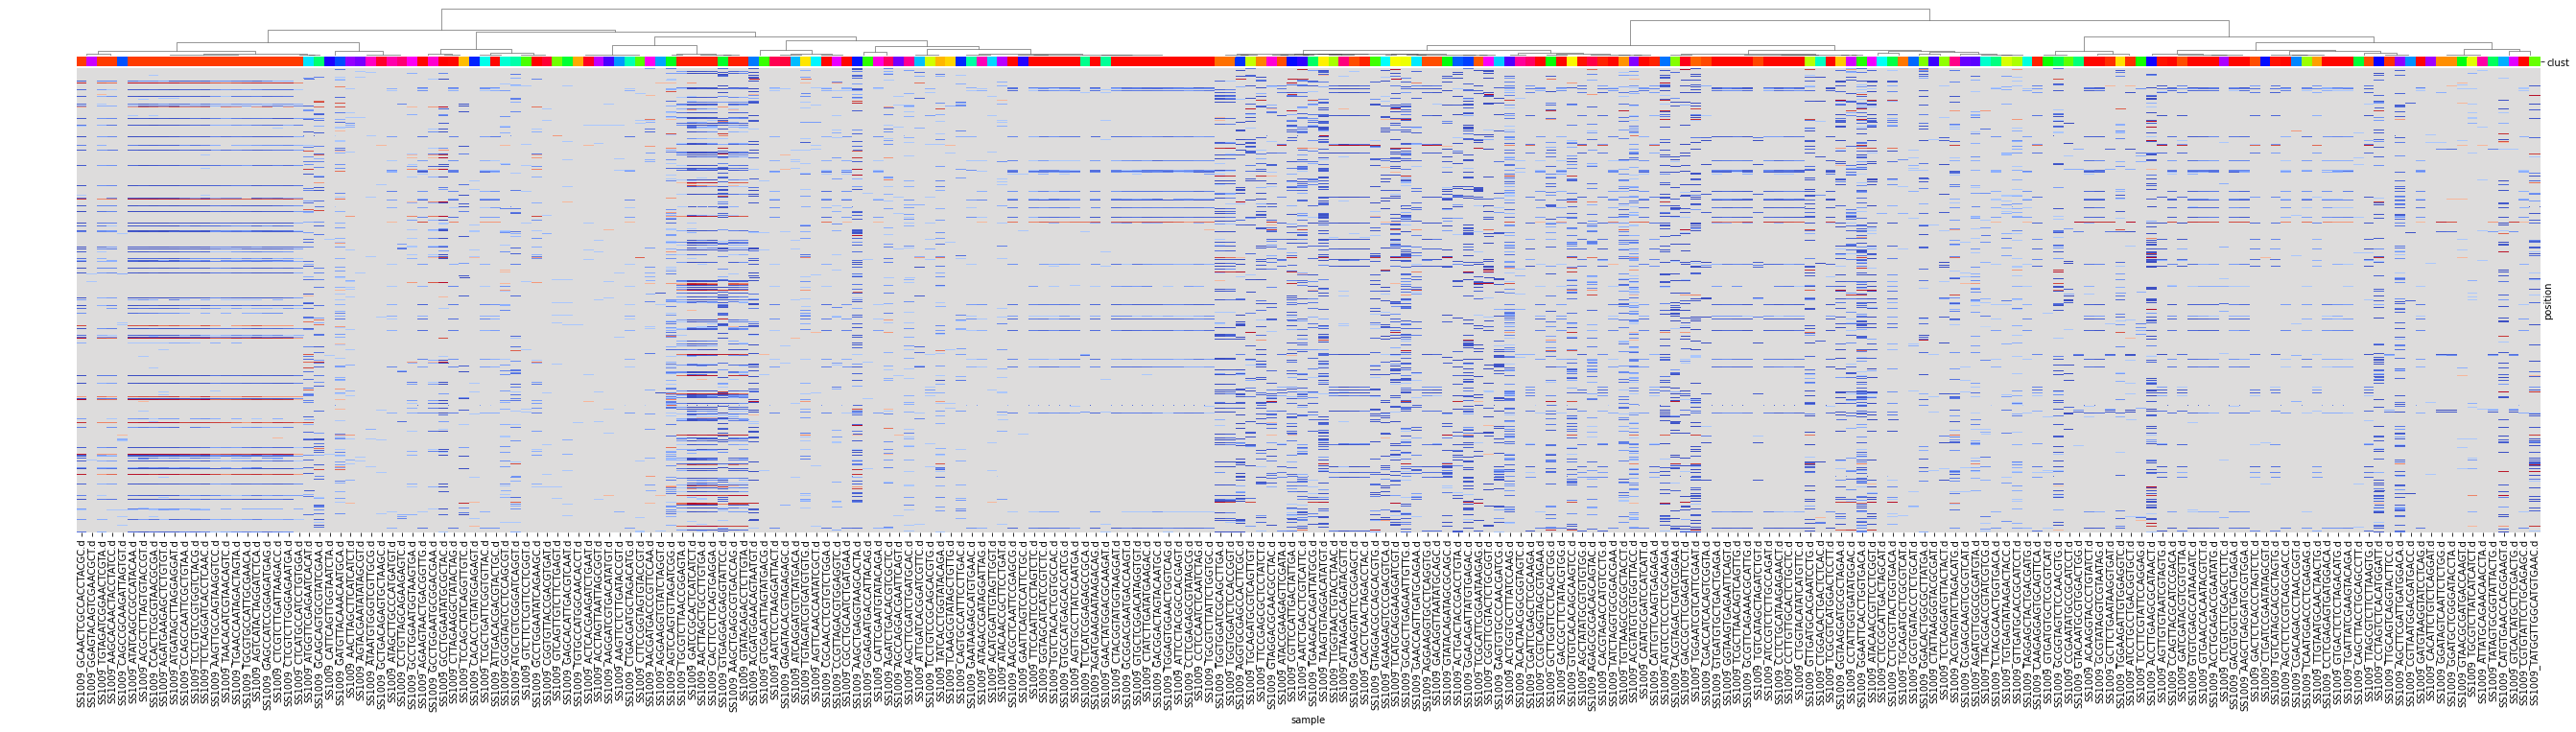

In [42]:
d = drplt_ucfmt_104345
distance_threshold = 0.2

drplt_agg = pd.Series(
    (
        AgglomerativeClustering(
            affinity='cosine',
            distance_threshold=distance_threshold,
            n_clusters=None,
            linkage='average'
        )
        .fit_predict(d.total_counts())
    ),
    d.sample,
    name='clust',
)

drplt_agg_pal = lib.plot.construct_ordered_pallete(drplt_agg, cm='hsv')

sf.plot.plot_metagenotype(
    d.random_sample(position=1000).to_world(),
    col_colors_func=lambda d: drplt_agg.to_xarray(),
#     col_linkage_func=lambda w: w.metagenotypes.linkage(pseudo=1.),
    row_col_annotation_cmap=mpl.cm.hsv,
)

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
No handles with labels found to put in legend.


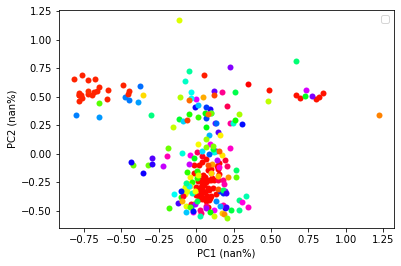

In [43]:
d = drplt_ucfmt_104345


lib.plot.ordination_plot(
    d.pdist(),
    ordin=lib.plot.nmds_ordination,
    meta=drplt_agg.to_frame(),
    colorby='clust',
    color_palette=drplt_agg_pal,
    ordin_kws={'is_dmat': True},
    fill_legend=False,
    scatter_kws=dict(lw=0),
)
None

In [44]:
drplt_derep_ucfmt_104345 = sf.data.Metagenotypes(
    drplt_ucfmt_104345
    .to_series()
    .reset_index()
    .rename(columns={0: 'tally'})
    .join(drplt_agg, on='sample')
    .join(drplt_ucfmt_104345_to_sample.set_index('lib_id'), on='sample')
    .groupby(['sample_id', 'clust', 'position', 'allele'])
    .sum()
    .astype(int)
    .reset_index()
    .assign(label=lambda x: x.sample_id + '_' + x.clust.astype(str))
    .set_index(['label', 'position', 'allele'])
    .rename_axis(index={'label': 'sample'})
    .tally
    .to_xarray()
)
print(drplt_ucfmt_104345.sizes, drplt_derep_ucfmt_104345.sizes)

Frozen({'sample': 238, 'position': 11058, 'allele': 2}) Frozen({'sample': 149, 'position': 11058, 'allele': 2})


In [45]:
# d = drplt_filt_derep.select_samples_with_coverage(0.1).data.

drplt_ucfmt_104345_strain_type = sf.estimation.strain_cluster(
    (
        drplt_derep_ucfmt_104345
        .select_samples_with_coverage(0.05)
        .to_estimated_genotypes(pseudo=1.0)
        .to_world()
    ),
    thresh=0.1,
)
                     
drplt_ucfmt_104345_strain_type_palette = lib.plot.construct_ordered_pallete(sorted(drplt_ucfmt_104345_strain_type.unique()), cm='Spectral')
drplt_ucfmt_104345_strain_type.value_counts()
drplt_ucfmt_104345_strain_type.name = 'drplt_type'

### Matched metagenomes

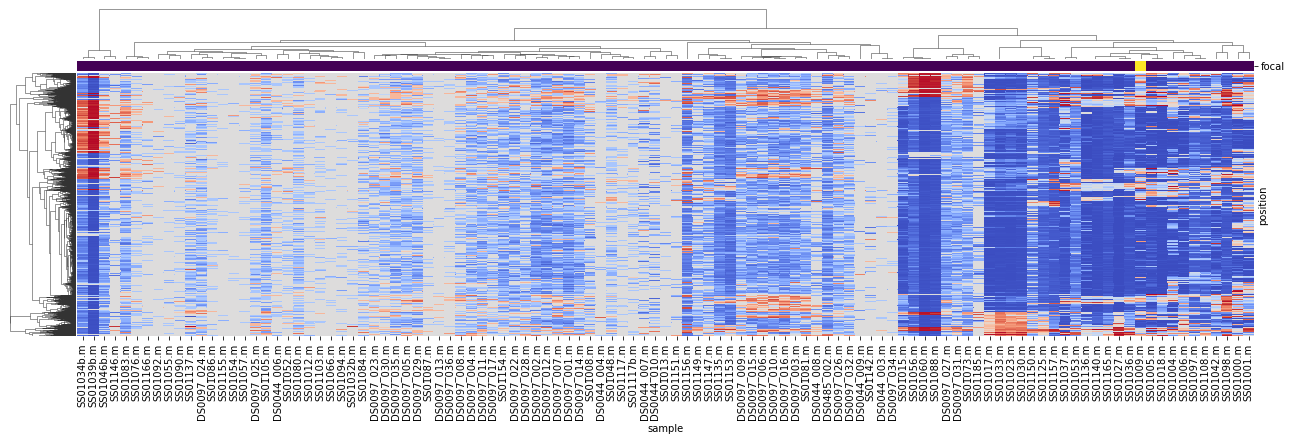

In [6]:
sf.plot.plot_metagenotype(
    mgen_ucfmt_104345.to_world(),
    col_linkage_func=lambda w: mgen_ucfmt_104345.linkage("sample"),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.isin(['SS01009.m']),
    )),
    scaley=5e-4 if mgen_ucfmt_104345.sizes['position'] > 1e2 else 1e-2
)

In [147]:
fit_ucfmt_104345.data

<xarray.Dataset>
Dimensions:        (allele: 2, position: 1000, sample: 109, strain: 40)
Coordinates:
  * strain         (strain) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * sample         (sample) object 'DS0044_003.m' 'DS0044_004.m' ... 'SS01185.m'
  * position       (position) object '10022' '1005292' ... '998852' '999220'
  * allele         (allele) object 'alt' 'ref'
Data variables:
    rho            (strain) float32 1.986e-05 0.009831 ... 0.001475 3.197e-06
    p              (sample, position) float32 0.008202 0.04008 ... 0.002972
    mu             (sample) float32 0.1075 0.1542 0.3963 ... 39.57 0.3325 1.448
    epsilon        (sample) float32 0.00786 0.007193 ... 0.005043 0.003365
    alpha          (sample) float32 200.0 200.0 200.0 ... 200.0 200.0 200.0
    m              (sample, position) float32 2.0 0.0 0.0 0.0 ... 5.0 3.0 13.0
    y              (sample, position) float32 0.0 0.0 0.0 0.0 ... 5.0 0.0 0.0
    genotypes      (strain, position) float32 0.004275 0.001119 ... 0.006755
    communities    (sample, strain) float32 2.013e-05 0.005998 ... 4.453e-07
    metagenotypes  (sample, position, allele) float32 0.0 2.0 0.0 ... 0.0 13.0
Attributes:
    gamma_hyper:            1e-10
    rho_hyper:              0.2
    pi_hyper:               0.5
    mu_hyper_mean:          1.0
    mu_hyper_scale:         1.0
    m_hyper_concentration:  1.0
    epsilon_hyper_mode:     0.01
    epsilon_hyper_spread:   1.5
    alpha_hyper_mean:       200
    alpha_hyper_scale:      1e-06

In [ ]:
nposition = 1000

np.random.seed(0)

# fit_ucfmt_104345, est_list, history_list = sf.workflow.fit_subsampled_metagenotypes_then_collapse_and_iteratively_refit_genotypes(
fit_ucfmt_104345, history = sf.workflow.fit_metagenotypes_simple(
    sf.model_zoo.NAMED_STRUCTURES['ssdd4_with_error'],
    mgen_ucfmt_104345.random_sample(position=nposition),
#     nposition=nposition,
#     npositionB=int(1e5),
    nstrain=40,
    hyperparameters=dict(
        gamma_hyper=1e-3,
#         rho_hyper=5.0,
#         pi_hyper=1.0,
    ),
    anneal_hyperparameters=dict(
        rho_hyper=dict(name='log', start=10.0, end=5.0, wait_steps=1000),
        pi_hyper=dict(name='log', start=5.0, end=1.0, wait_steps=1000),
    ),
    annealiter=4000,
#     stage2_hyperparameters=dict(gamma_hyper=1.0),
#     diss_thresh=0.02,
#     frac_thresh=1e-3,
    estimation_kwargs=dict(
        jit=True, catch_keyboard_interrupt=True, ignore_jit_warnings=True, maxiter=int(1e6),
    ),
    device='cuda',
#     seed=1,
)

[2021-11-23 13:32:54.108154] START: Fitting 40 strains with data shape Frozen({'sample': 109, 'position': 1000, 'allele': 2}).


In [169]:
sf.evaluation.metagenotype_error(fit_ucfmt_104345, fit_ucfmt_104345)[0]

0.07321030646562576

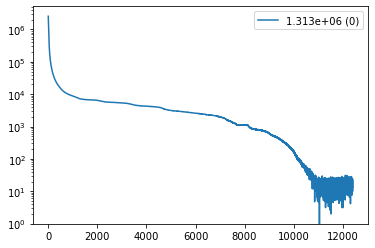

In [170]:
sf.plot.plot_loss_history(history)

strain
6     0.203599
10    0.199105
14    0.198508
1     0.186171
8     0.124994
39    0.030352
4     0.011106
Name: communities, dtype: float32

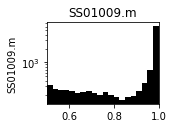

In [171]:
sample = 'SS01009.m'

sf.plot.plot_metagenotype_frequency_spectrum(mgen_ucfmt_104345.to_world(), sample_list=[sample])
plt.yscale('log')

sample_community = fit_ucfmt_104345.data.sel(sample=sample).communities.to_series().sort_values(ascending=False)
strain_list = idxwhere(sample_community > 0.01)
sample_community.head(7)

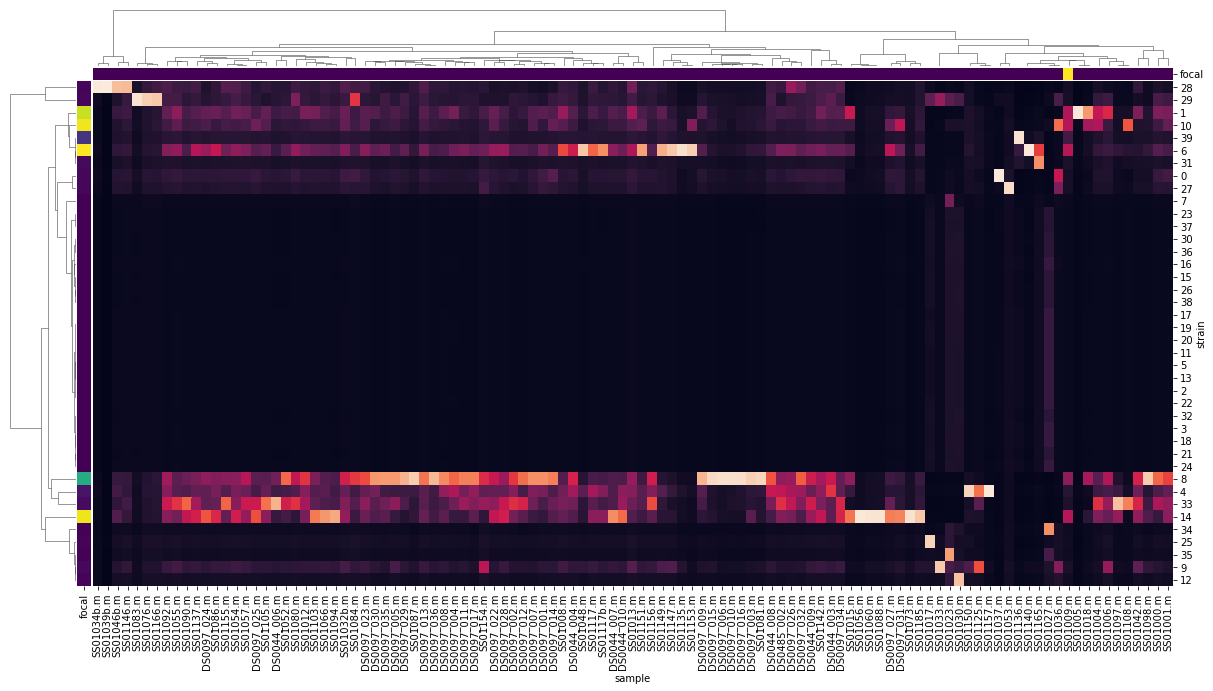

In [172]:
# sf.plot.plot_metagenotype(
#     fit_ucfmt_104345,
#     col_colors_func=lambda w: xr.Dataset(dict(
#         focal=w.sample.isin(['SS01009.m']),
#     )),
# )
sf.plot.plot_community(
    fit_ucfmt_104345,
    col_linkage_func=lambda w: mgen_ucfmt_104345.linkage("sample"),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.isin(['SS01009.m']),
    )),
    row_colors_func=lambda w: xr.Dataset(dict(
        focal=w.communities.data.sel(sample='SS01009.m').to_series(),
    )),
)

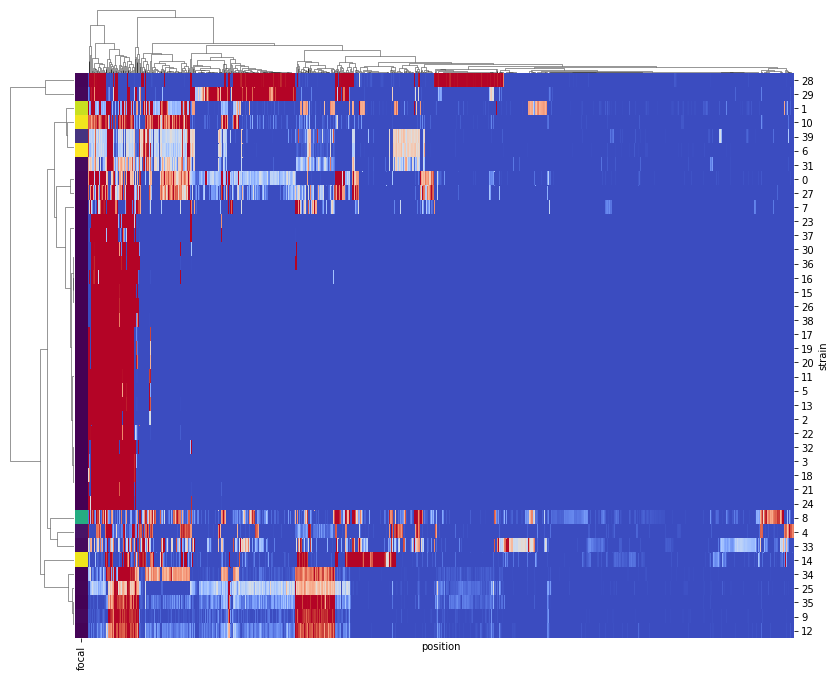

In [173]:
sf.plot.plot_genotype(
    fit_ucfmt_104345,
#     col_linkage_func=lambda w: mgen_ucfmt_104345.linkage("sample"),
    row_colors_func=lambda w: xr.Dataset(dict(
        focal=w.communities.data.sel(sample='SS01009.m').to_series(),
    )),

)

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 4., 5., 4., 3., 6.,
        0., 1., 4., 2., 1., 3., 5., 3., 3., 5., 1., 1., 6., 2., 3., 2., 0.,
        1., 1., 2., 2., 2., 2., 1., 6., 3., 1., 2., 1., 2., 8., 2., 5.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

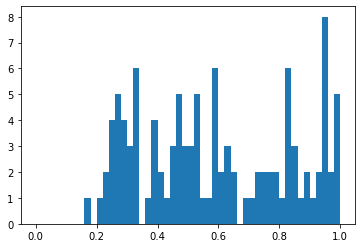

In [174]:
plt.hist(fit_ucfmt_104345.communities.max("strain").values, bins=np.linspace(0, 1, num=51))
# plt.yscale('log')

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))
No handles with labels found to put in legend.


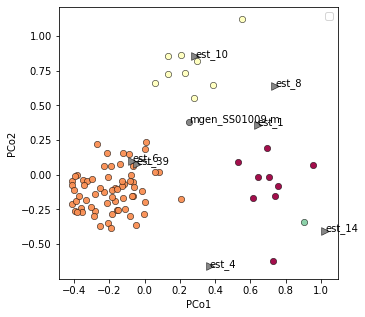

In [175]:
e = fit_ucfmt_104345
sample_list = [s for s in e.sample.values if s in ['SS01009.m']]


w = sf.data.Genotypes.concat(dict(
    est=e.genotypes.mlift('sel', strain=strain_list),
#     othere=e.genotypes,
    mgen=e.metagenotypes.mlift('sel', sample=sample_list).mlift('sel', position=e.position).to_estimated_genotypes(),
#     otherm=mgen_filt.mlift('sel', position=e.position).to_estimated_genotypes(),
    drplt=drplt_derep_ucfmt_104345.select_samples_with_coverage(0.05).mlift('sel', position=e.position).to_estimated_genotypes(),
), dim='strain')

def _assign_gtype(x):
    return x.index.to_series().str.split('_').apply(lambda x: x[0])

fig, ax = plt.subplots(figsize=(5, 5))

ax, ordin, *_ = lib.plot.ordination_plot(
    w.pdist(),
    ordin=lib.plot.nmds_ordination,
    meta=pd.DataFrame(dict(
        clust=drplt_ucfmt_104345_strain_type.rename(lambda s: 'drplt_' + s),
        is_est=w.strain.str.startswith('est_').to_series(),
    )).fillna(-1),
    colorby='clust',
    color_palette=drplt_ucfmt_104345_strain_type_palette,
    markerby='is_est',
    marker_palette={True: '>', False: 'o'},
    zorderby='is_est',
    markersizeby='is_est',
    markersize_palette={True: 60, False: 40},
    ordin_kws={'is_dmat': True},
    fill_legend=False,
    scatter_kws=dict(lw=0.5, alpha=0.95),
    ax=ax
)

ax.set_xlabel('PCo1')
ax.set_ylabel('PCo2')

ordin['gtype'] = ordin.index.to_series().str.split('_').apply(lambda x: x[0])
for name, d1 in ordin[ordin.gtype.isin(['est', 'mgen'])].iterrows():
    ax.annotate(name, xy=d1[['PC1', 'PC2']].to_list())
None

/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:26: RuntimeWarning: invalid value encountered in double_scalars
  wmean_dist = ((weight * dist).sum()) / ((weight.sum()))


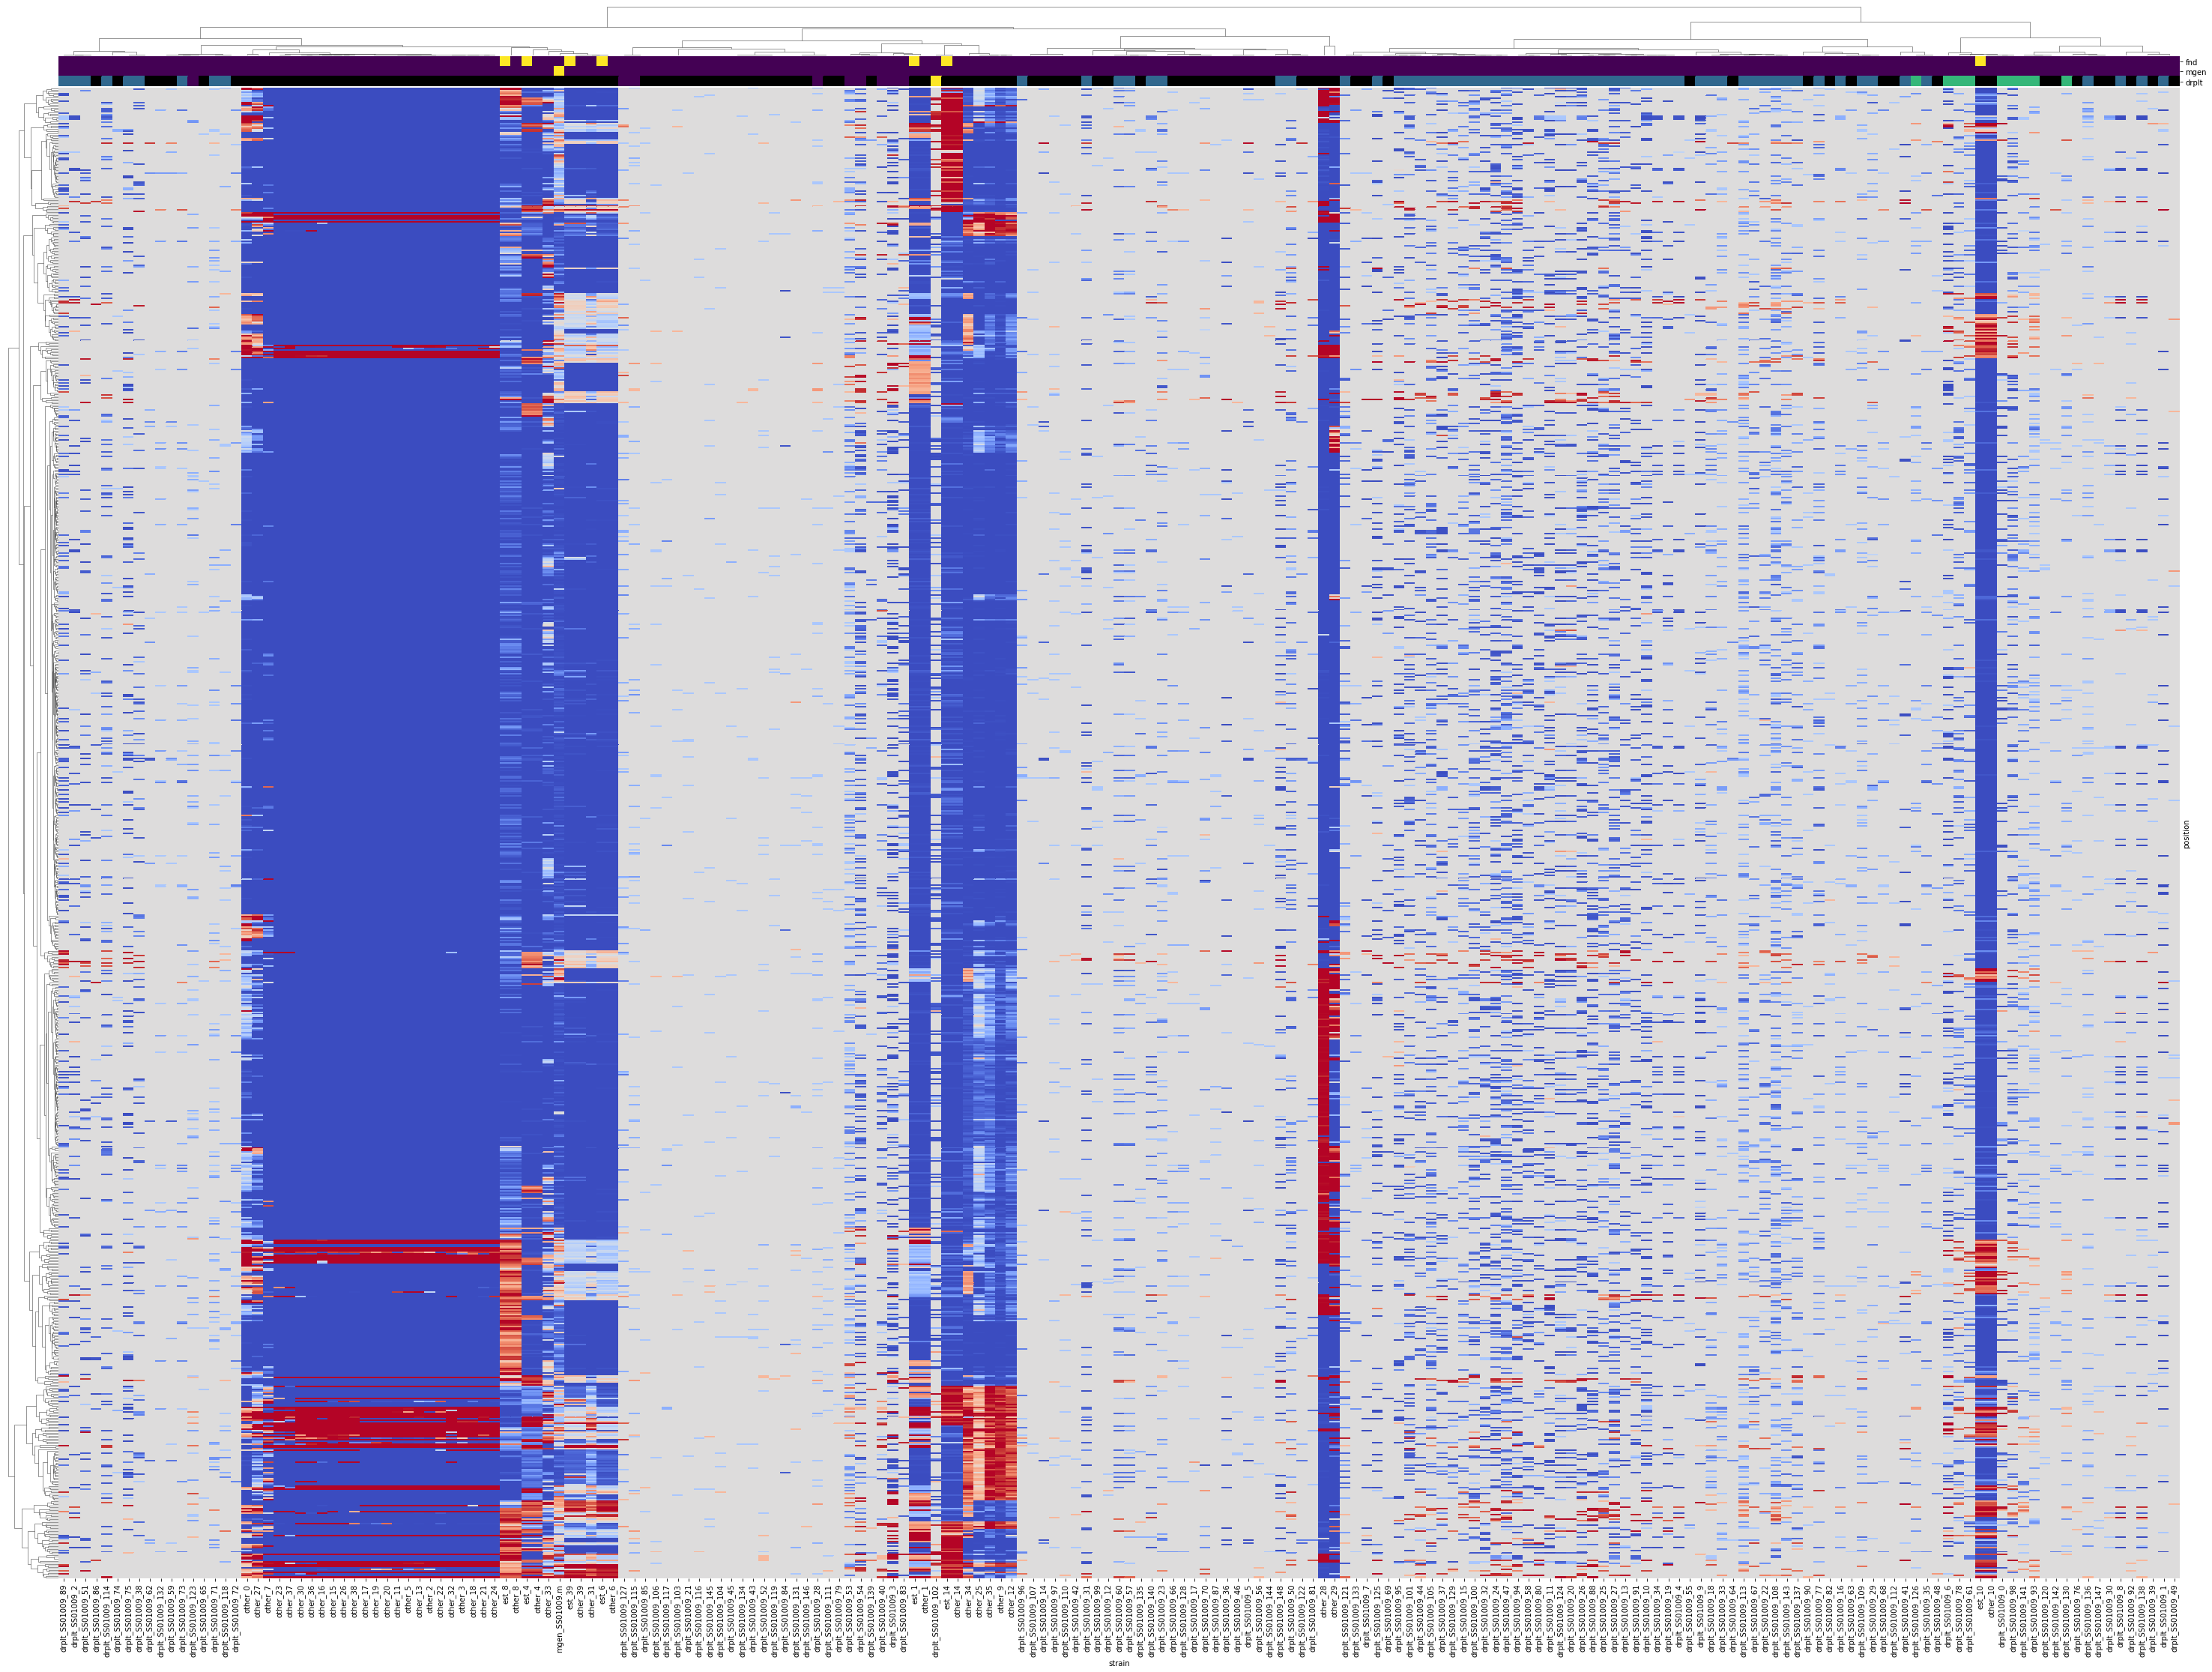

In [176]:
e = fit_ucfmt_104345
sample_list = [s for s in e.sample.values if s in ['SS01009.m']]

d = sf.data.Genotypes.concat(
        dict(
        est=e.genotypes.mlift('sel', strain=strain_list),
        other=e.genotypes,
        mgen=(
            mgen_ucfmt_104345
            .mlift('sel', sample=sample_list)
            .mlift('sel', position=e.position)
            .to_estimated_genotypes()
        ),
        drplt=drplt_derep_ucfmt_104345.mlift('sel', position=e.position).to_estimated_genotypes(),
    ),
    dim='strain'
)

sf.plot.plot_genotype(
    d.to_world(),
    col_colors_func=None,
    row_colors_func=lambda w: xr.Dataset(dict(
        fnd=w.strain.str.startswith('est_'),
        mgen=w.strain.str.startswith('mgen_'),
        drplt=w.strain.to_dataframe().join(drplt_ucfmt_104345_strain_type.rename(lambda s: 'drplt_' + s)).drplt_type,
    )),
    col_linkage_func=lambda w: e.metagenotypes.linkage("position"),
    scalex=3e-2 if len(e.position) < 3000 else 1e-3,
    transpose=True,
#     row_linkage_func=lambda w: w.genotypes.linkage(),
#     col_linkage_func=None,
#     col_cluster=False,
#     row_cluster=False,
)

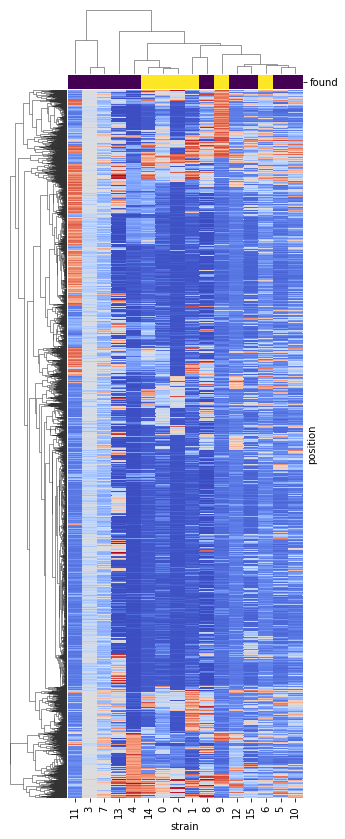

In [107]:
sf.plot.plot_genotype(
    fit_ucfmt_104345,
    col_linkage_func=lambda w: w.metagenotypes.linkage("position"),
    row_colors_func=lambda w: xr.Dataset(dict(
        found=w.strain.isin(strain_list),
    )),
    scalex=1e-2 if len(e.position) < 3000 else 1e-3,
    transpose=True,
)

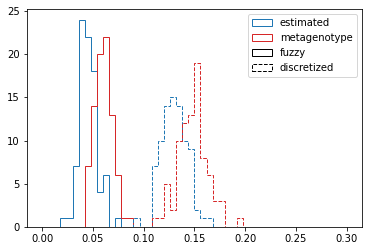

In [109]:
stem = 'data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.fit-sfacts12-s100-g2000-seed3'
_fit_ucfmt_104345 = sf.data.World.load(f'{stem}.world.nc')



_drplt = drplt_derep_ucfmt_104345.select_samples_with_coverage(0.05).to_estimated_genotypes().to_world()
_fit = _fit_ucfmt_104345.genotypes.to_world()
_fit_and_found = _fit_ucfmt_104345.genotypes.mlift('sel', strain=strain_list).to_world()
_mgen = _fit_ucfmt_104345.metagenotypes.mlift('sel', sample=sample_list).to_estimated_genotypes().to_world()

_fit_disc = _fit_ucfmt_104345.genotypes.discretized().to_world()
_fit_and_found_disc = _fit_ucfmt_104345.genotypes.mlift('sel', strain=strain_list).discretized().to_world()
_mgen_disc = _fit_ucfmt_104345.metagenotypes.mlift('sel', sample=sample_list).to_estimated_genotypes().discretized().to_world()


bins = np.linspace(0, 0.3, num=51)
# plt.hist(sf.evaluation.match_genotypes(_drplt, _fit)[1], bins=bins, color='tab:green', label='estimated (all)', histtype='step', linestyle='-')
plt.hist(sf.evaluation.match_genotypes(_drplt, _fit_and_found)[1], bins=bins, color='tab:blue', label='estimated', histtype='step', linestyle='-')
plt.hist(sf.evaluation.match_genotypes(_drplt, _mgen)[1], bins=bins, color='tab:red', label='metagenotype', histtype='step', linestyle='-')
# plt.hist(sf.evaluation.match_genotypes(_drplt, _fit_disc)[1], bins=bins, color='tab:green', histtype='step', linestyle='--')
plt.hist(sf.evaluation.match_genotypes(_drplt, _fit_and_found_disc)[1], bins=bins, color='tab:blue', histtype='step', linestyle='--')
plt.hist(sf.evaluation.match_genotypes(_drplt, _mgen_disc)[1], bins=bins, color='tab:red', histtype='step', linestyle='--')

plt.hist([], bins=bins, color='black', histtype='step', linestyle='-', label='fuzzy')
plt.hist([], bins=bins, color='black', histtype='step', linestyle='--', label='discretized')
plt.legend()

In [92]:
# Genotypes observed in droplets are more similar to the genotypes inferred by sfacts than
# a naive genotype constructed from the observed metagenotype, especially when considering the
# discretized (consensus sequences)

print(sf.evaluation.match_genotypes(_drplt, _fit_and_found)[1].mean(), sf.evaluation.match_genotypes(_drplt, _fit_and_found_disc)[1].mean())
print(sf.evaluation.match_genotypes(_drplt, _fit)[1].mean(), sf.evaluation.match_genotypes(_drplt, _fit_disc)[1].mean())

0.04501701774947978 0.13045989421458348
0.020412165961153323 0.03402620783628235


## Large-scale genetics

### 102492

In [1047]:
gtpro_fit_102492 = sf.data.World.load('data/zshi.sp-102492.metagenotype.filt-poly05-cvrg25-g500.fit-sfacts13-s500-g500-seed4.world.nc')
gtpro_fit_102492.sizes

Frozen({'strain': 280, 'sample': 11860, 'position': 500, 'allele': 2})

(array([64118., 15655.,  7976.,  5234.,  3201.,  2664.,  1741.,  1502.,
         1484.,  1099.,   992.,   666.,  1341.,   608.,   534.,   565.,
         1281.,   482.,   430.,   423.,   462.,   385.,   409.,   627.,
         3286.,   553.,   308.,   311.,   323.,   354.,   321.,   321.,
          335.,   500.,   349.,   351.,   375.,   493.,   317.,   463.,
          424.,   500.,   565.,   611.,   705.,   810.,  1096.,  1545.,
         2705.,  8200.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

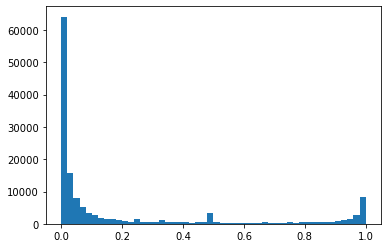

In [1048]:
plt.hist(gtpro_fit_102492.genotypes.values.flatten(), bins=np.linspace(0, 1, num=51))
# plt.yscale('log')

(array([   0.,    0.,    0.,    0.,    4.,   24.,   51.,  125.,  211.,
         287.,  354.,  364.,  376.,  389.,  403.,  373.,  336.,  330.,
         353.,  307.,  301.,  252.,  274.,  256.,  230.,  188.,  199.,
         191.,  154.,  157.,  147.,  142.,  128.,  123.,  127.,  104.,
         101.,  120.,  121.,  119.,  104.,  130.,  118.,  136.,  130.,
         137.,  181.,  187.,  344., 2672.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

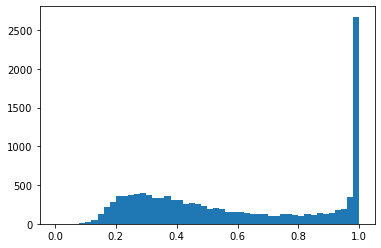

In [1049]:
plt.hist(gtpro_fit_102492.communities.max("strain").values.flatten(), bins=np.linspace(0, 1, num=51))
# plt.yscale('log')

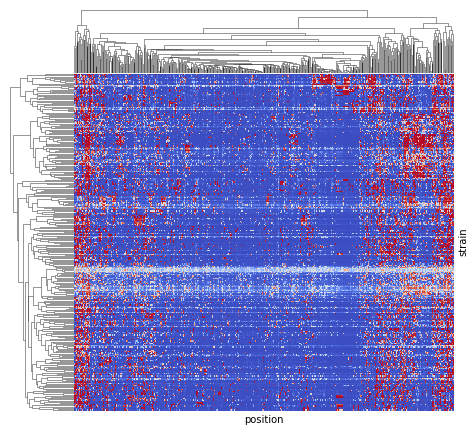

In [1051]:
sf.plot.plot_genotype(gtpro_fit_102492, scaley=2e-2, yticklabels=0)

In [1052]:
gtpro_fit_102492_filt = gtpro_fit_102492.genotypes.mlift('sel', strain=idxwhere(gtpro_fit_102492.genotypes.entropy().to_series() < 0.25))

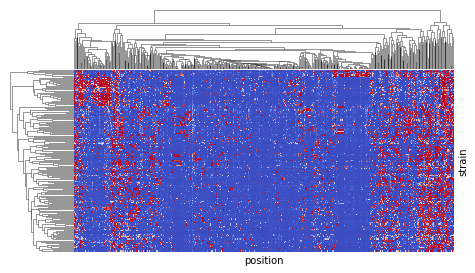

In [1053]:
sf.plot.plot_genotype(gtpro_fit_102492_filt.to_world(), scaley=2e-2, yticklabels=0)

#### Reference genomes

In [1055]:
gtpro_ref_102492_mgen = sf.data.Metagenotypes.load('data/gtprodb.sp-102492.genotype.nc')
gtpro_ref_102492 = gtpro_ref_102492_mgen.to_estimated_genotypes(pseudo=0)

(array([ 0.,  0.,  1.,  8., 13., 16., 30., 22., 28., 22., 17., 11.,  6.,
         6.,  3.,  9.,  5.,  6., 10., 12.,  4.,  6.,  6.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  2.,  3.,  2.,  2.,  0.,  1.,  1.,  1.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

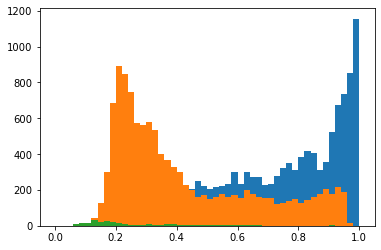

In [1079]:
plt.hist(gtpro_fit_102492.metagenotypes.to_estimated_genotypes(pseudo=1).entropy(), bins=np.linspace(0, 1, num=51))
plt.hist(gtpro_fit_102492.metagenotypes.to_estimated_genotypes(pseudo=0.01).entropy(), bins=np.linspace(0, 1, num=51))
plt.hist(gtpro_fit_102492.genotypes.entropy(), bins=np.linspace(0, 1, num=51))

# Estimated genotypes are much lower entropy than the estimates we would have gotten from
# metagenotypes directly (even using a small-pseudocount approach).

In [1063]:
gtpro_mgen_102492_genotypes = gtpro_fit_102492.metagenotypes.to_estimated_genotypes()
gtpro_mgen_102492_genotypes_filt = gtpro_mgen_102492_genotypes.mlift('sel', strain=idxwhere(gtpro_mgen_102492_genotypes.entropy().to_series() < 0.25))


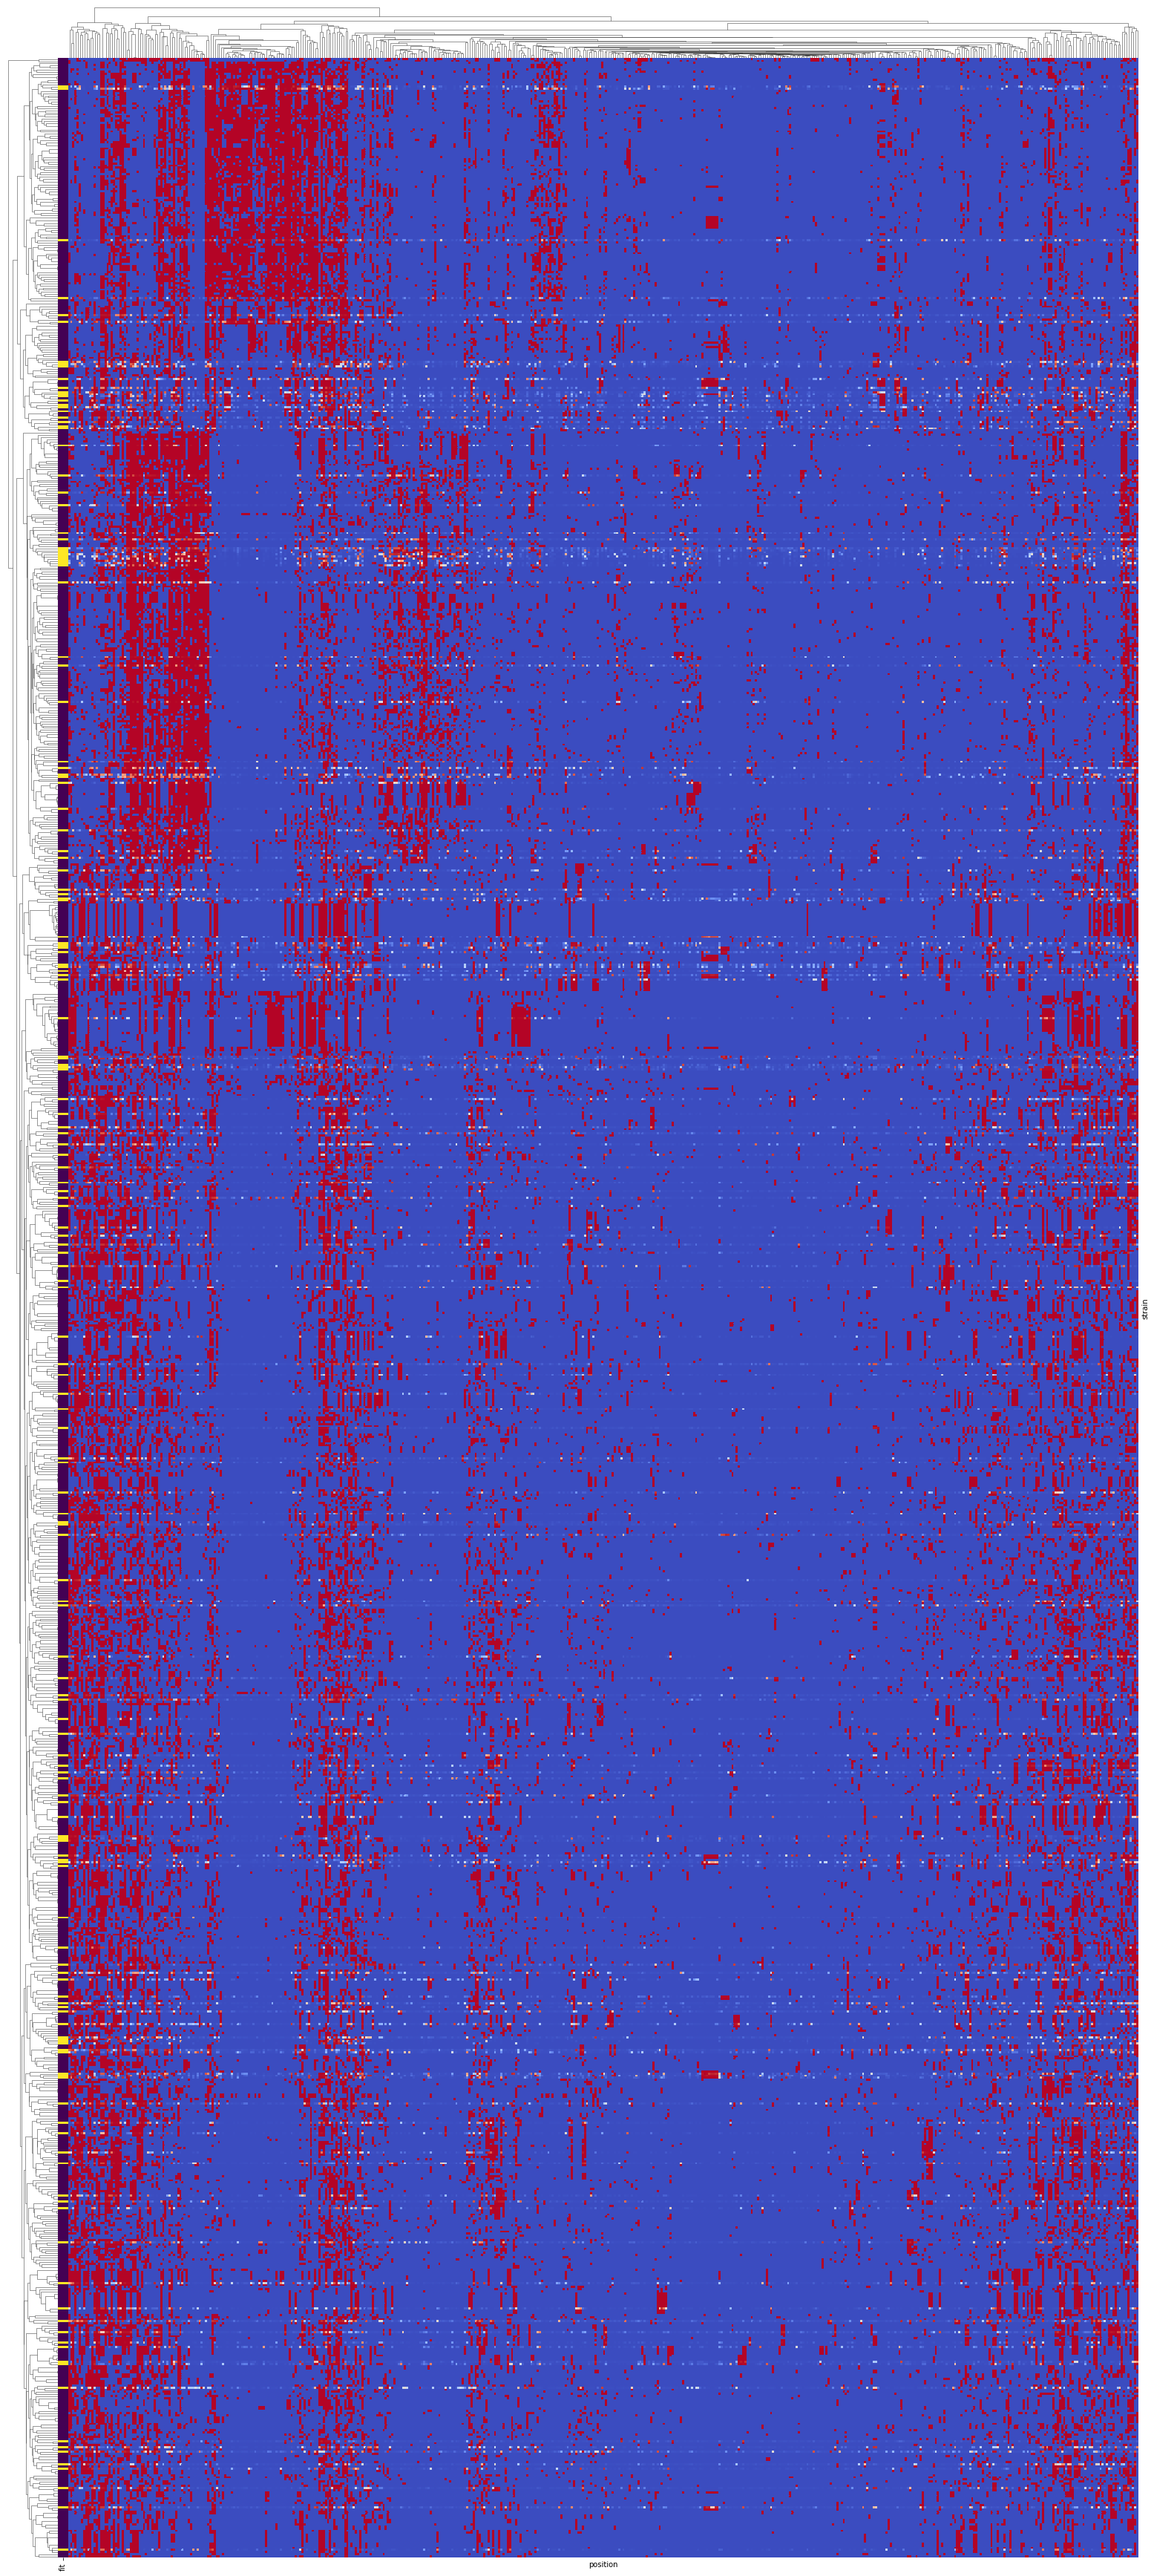

In [1056]:
g_fit = gtpro_fit_102492_filt
g_ref = gtpro_ref_102492.mlift('sel', position=g_fit.position)

g = sf.data.Genotypes.concat(dict(
    fit=g_fit,
    ref=g_ref,
), dim='strain')

sf.plot.plot_genotype(
    g.to_world(),
    row_colors_func=lambda w: xr.Dataset(dict(
        fit=w.strain.str.startswith('fit_'),
    )),
    scaley=4e-2,
    scalex=4e-2,
    yticklabels=0,
)

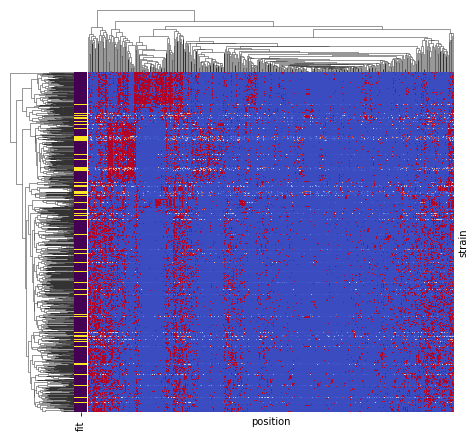

In [1057]:
sf.plot.plot_genotype(
    g.to_world(),
    row_colors_func=lambda w: xr.Dataset(dict(
        fit=w.strain.str.startswith('fit_'),
    )),
    scaley=4e-3,
    scalex=1e-2,
    yticklabels=0,
)

### 102506

In [1029]:
# gtpro_fit_102506 = sf.data.World.load('data/zshi.sp-102506.metagenotype.filt-poly05-cvrg75-g500.fit-sfacts13-s200-g500-seed1.world.nc')
gtpro_fit_102506 = sf.data.World.load('data/zshi.sp-102506.metagenotype.filt-poly05-cvrg25-g500.fit-sfacts13-s500-g500-seed0.world.nc')
gtpro_fit_102506.sizes

Frozen({'strain': 245, 'sample': 9232, 'position': 500, 'allele': 2})

(array([34090.,  8501.,  6299.,  5305.,  3774.,  3843.,  2925.,  2977.,
         3005.,  1460.,  2727.,  1071.,  3539.,   796.,   919.,   790.,
         3951.,   571.,   725.,   635.,  1010.,   720.,   674.,   532.,
         4713.,  1702.,   495.,   564.,   576.,   623.,   602.,   584.,
          409.,  1563.,   435.,   593.,   402.,  1093.,   511.,   888.,
          478.,   792.,   730.,   683.,   816.,   828.,  1001.,  1234.,
         1877.,  7469.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

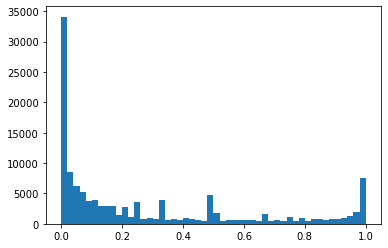

In [1026]:
plt.hist(gtpro_fit_102506.genotypes.values.flatten(), bins=np.linspace(0, 1, num=51))
# plt.yscale('log')

(array([   0.,    0.,    0.,    0.,    0.,    2.,    5.,   17.,   33.,
          52.,   71.,   80.,  108.,  131.,  164.,  160.,  185.,  202.,
         177.,  237.,  196.,  204.,  210.,  242.,  196.,  204.,  210.,
         183.,  197.,  189.,  170.,  171.,  193.,  162.,  150.,  140.,
         160.,  165.,  169.,  129.,  150.,  136.,  171.,  188.,  201.,
         215.,  272.,  408.,  585., 1642.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

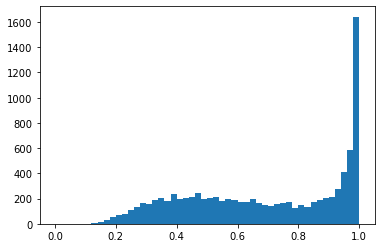

In [1027]:
plt.hist(gtpro_fit_102506.communities.max("strain").values.flatten(), bins=np.linspace(0, 1, num=51))
# plt.yscale('log')

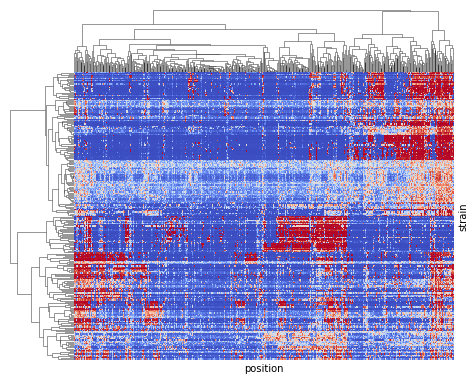

In [1030]:
sf.plot.plot_genotype(gtpro_fit_102506, scaley=2e-2, yticklabels=0)

In [1031]:
gtpro_fit_102506_filt = gtpro_fit_102506.genotypes.mlift('sel', strain=idxwhere(gtpro_fit_102506.genotypes.entropy().to_series() < 0.25))

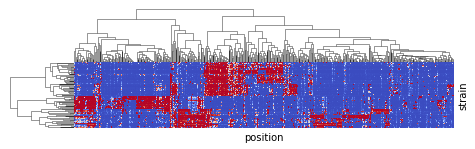

In [1032]:
sf.plot.plot_genotype(gtpro_fit_102506_filt.to_world(), scaley=2e-2, yticklabels=0)

#### Reference genomes

In [918]:
gtpro_ref_102506_mgen = sf.data.Metagenotypes.load('data/gtprodb.sp-102506.genotype.nc')
gtpro_ref_102506 = gtpro_ref_102506_mgen.to_estimated_genotypes(pseudo=0)

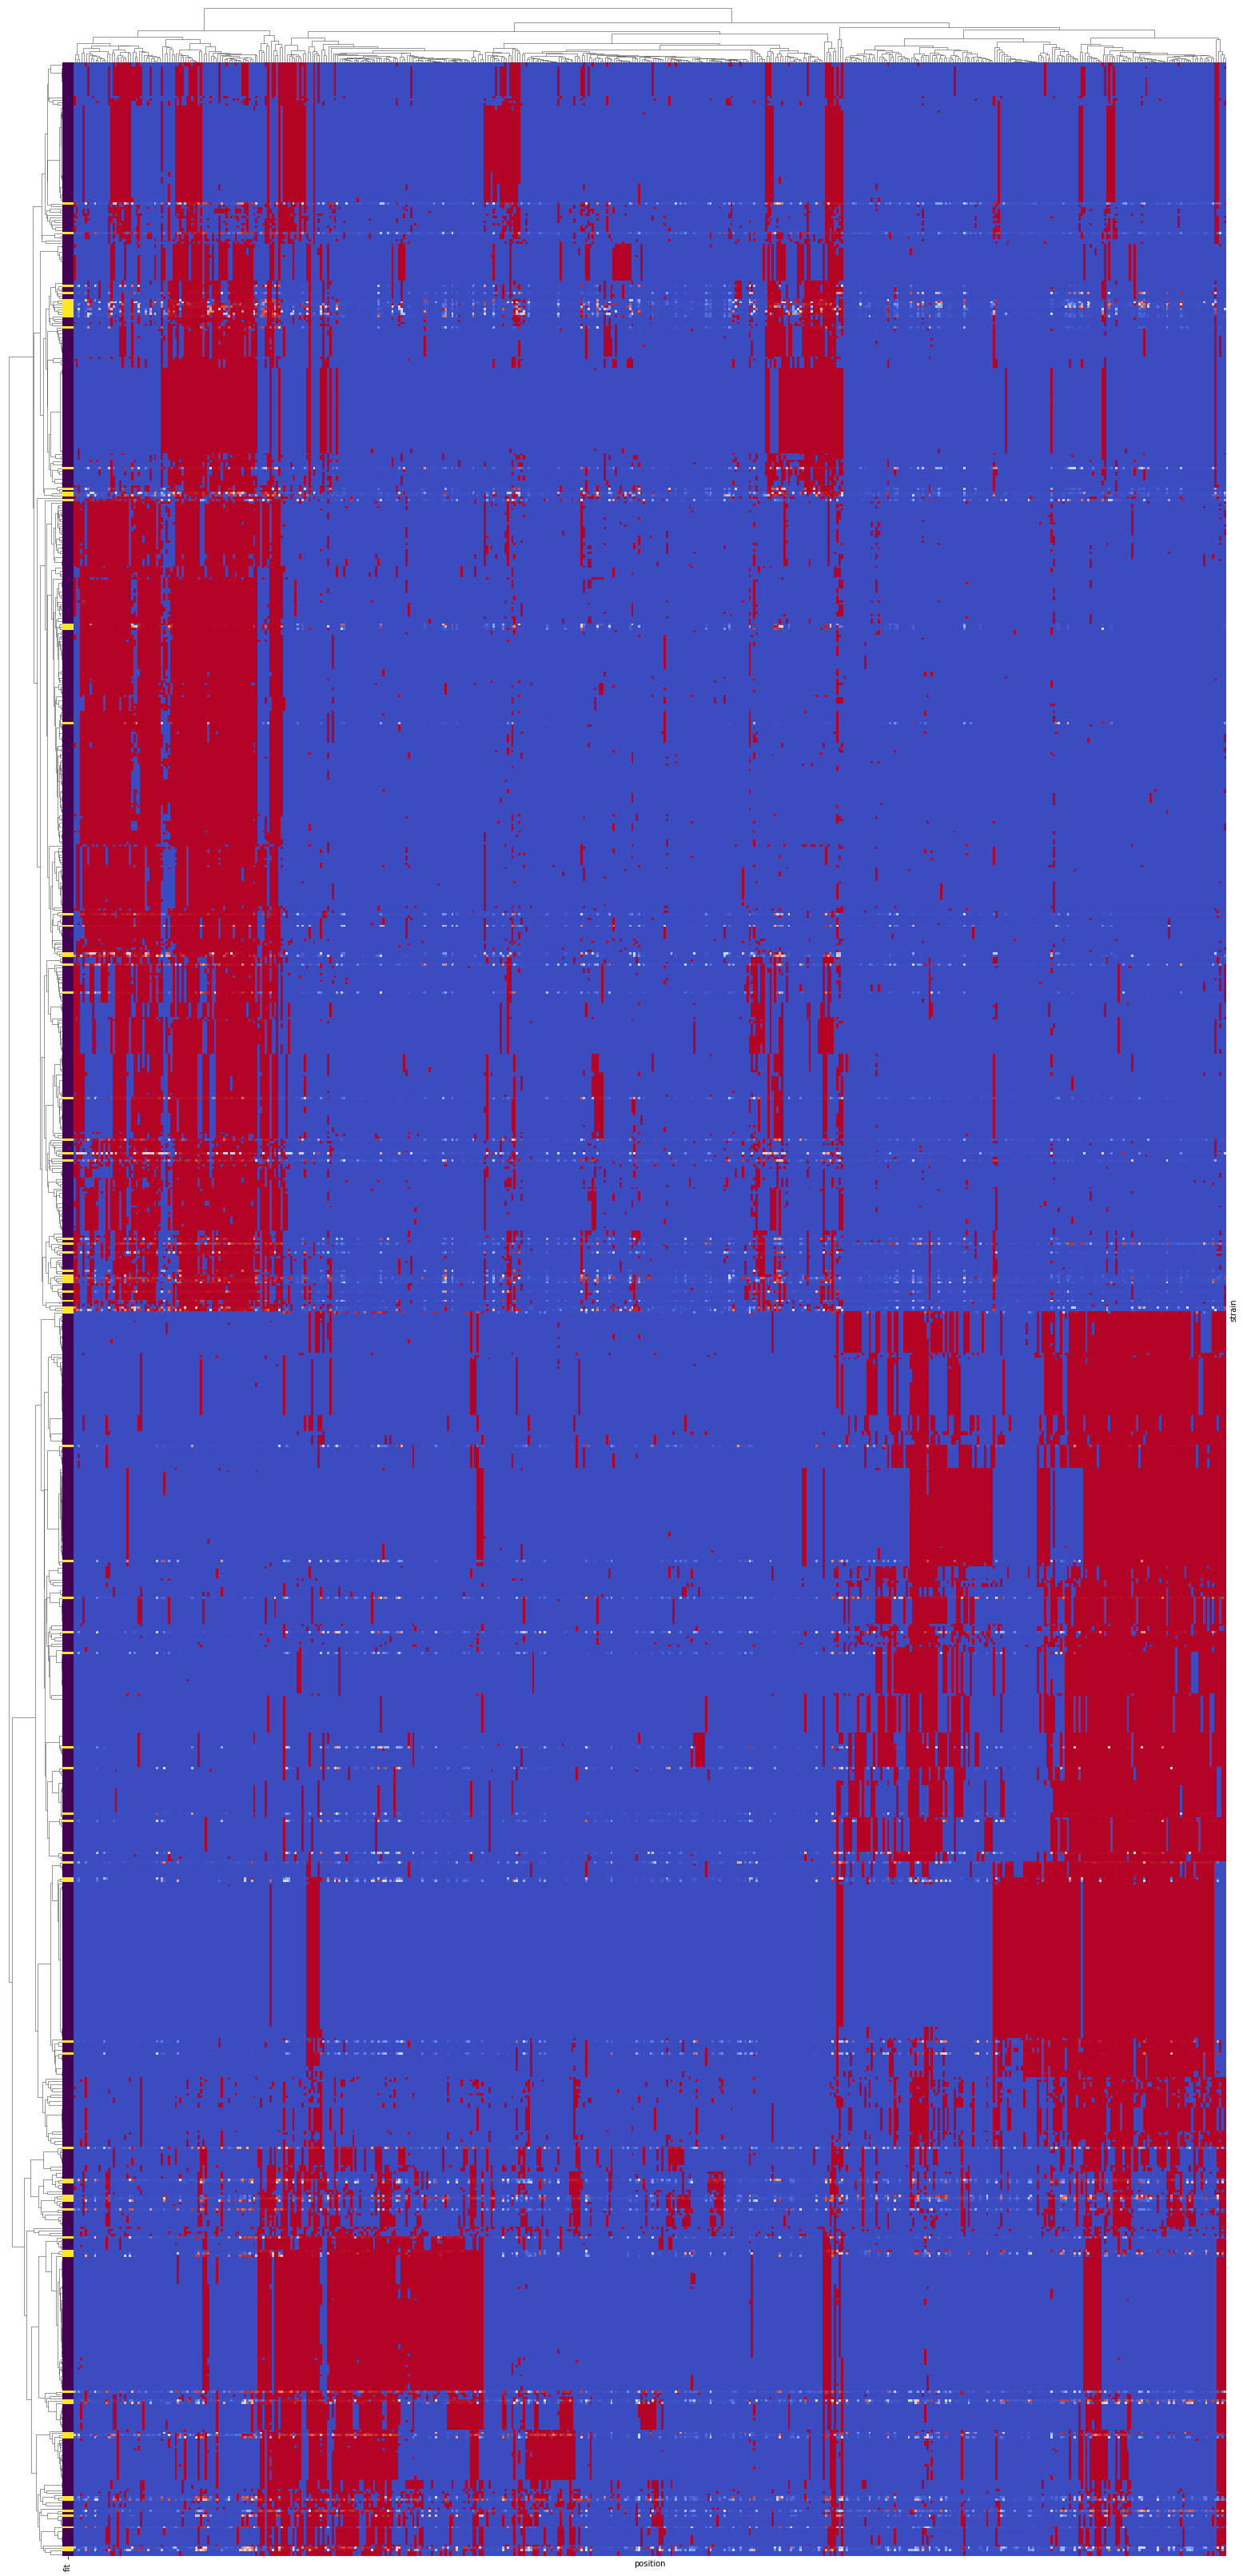

In [1033]:
g_fit = gtpro_fit_102506_filt
g_ref = gtpro_ref_102506.mlift('sel', position=g_fit.position)

g = sf.data.Genotypes.concat(dict(
    fit=g_fit,
    ref=g_ref,
), dim='strain')

sf.plot.plot_genotype(
    g.to_world(),
    row_colors_func=lambda w: xr.Dataset(dict(
        fit=w.strain.str.startswith('fit_'),
    )),
    scaley=4e-2,
    scalex=4e-2,
    yticklabels=0,
)

# This cluster-diagram shows that my reconstructions are consistent with what's in the database for E. coli
# I don't get any SUPER different strains than what's already been seen (but this may not be the case for less
# well studied organisms.

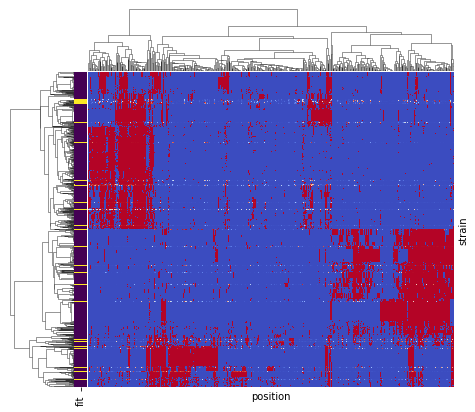

In [1034]:
sf.plot.plot_genotype(
    g.to_world(),
    row_colors_func=lambda w: xr.Dataset(dict(
        fit=w.strain.str.startswith('fit_'),
    )),
    scaley=4e-3,
    scalex=1e-2,
    yticklabels=0,
)

# I'm also able to recapitulate many of the same divisions that are found in the reference data
# I have strains from every part of the tree.
# Just looking at it, I should get similar estimates for LD
# (and presumably for LD decay with distance along the genome)

In [7]:
position_meta_102506 = pd.read_table(
    'ref/gtpro/variants_main.covered.hq.snp_dict.tsv',
    names=['species_id', 'position', 'contig', 'contig_position', 'ref', 'alt']
).set_index('position')[lambda x: x.species_id.isin([102506])]

position_meta_102506

species_id        contig  contig_position ref alt
position                                                   
29904         102506  QFSG01000004              980   C   T
30035         102506  QFSG01000004             1111   T   A
30046         102506  QFSG01000004             1122   T   A
30048         102506  QFSG01000004             1124   G   A
30053         102506  QFSG01000004             1129   C   T
...              ...           ...              ...  ..  ..
5712804       102506  QFSG01000485             5000   A   C
5712807       102506  QFSG01000485             5003   A   T
5712812       102506  QFSG01000485             5008   C   T
5712828       102506  QFSG01000485             5024   A   G
5712840       102506  QFSG01000485             5036   A   G

[99776 rows x 5 columns]

In [954]:
g = gtpro_ref_102506
strain_diss = pairwise_distances(g.values, metric='euclidean', n_jobs=12)
strain_diss = (strain_diss**2 / g.sizes['position'])
strain_diss = pd.DataFrame(strain_diss, index=g.strain.to_series(), columns=g.strain.to_series())

In [955]:
clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.02, affinity='precomputed', linkage='complete').fit_predict(strain_diss)
clust = pd.Series(clust, index=strain_diss.index)

In [965]:
clust.value_counts()

50     67
9      40
52     37
111    32
16     28
       ..
269     1
271     1
199     1
248     1
290     1
Length: 292, dtype: int64

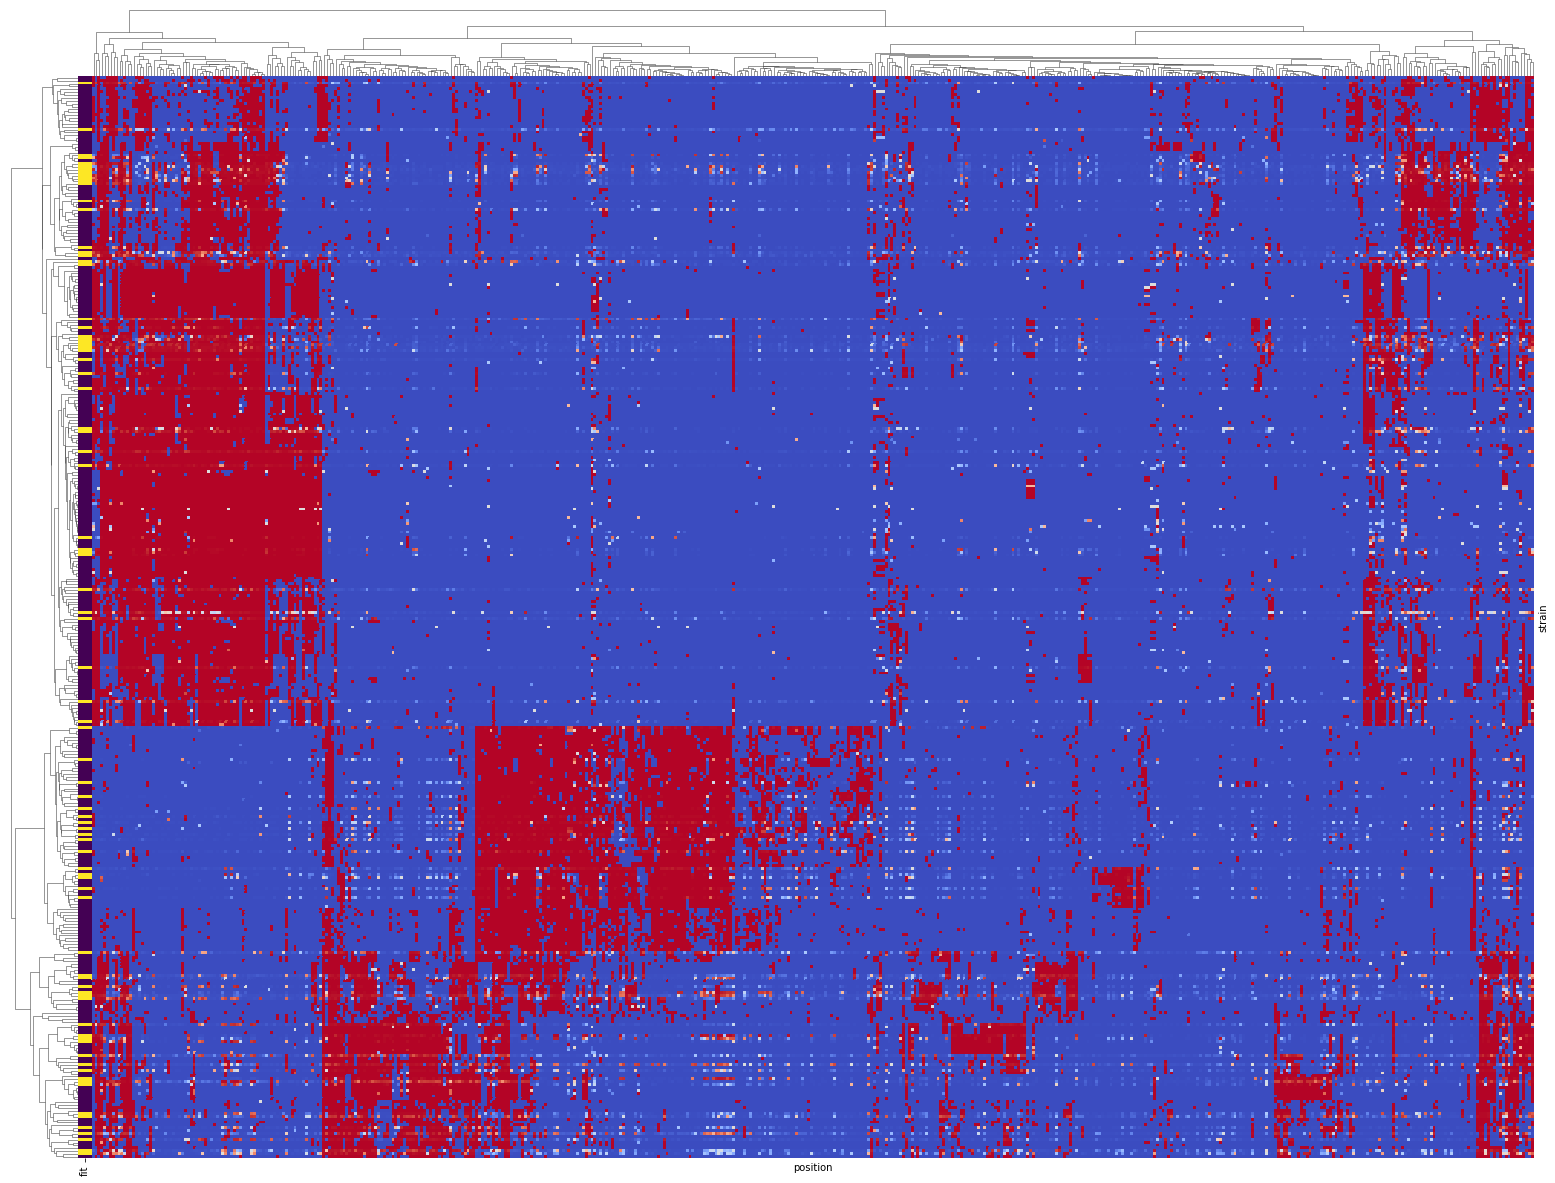

In [1035]:
gtpro_ref_102506_derep = sf.data.Genotypes(gtpro_ref_102506.data.groupby(clust.to_xarray()).mean().rename({'group': 'strain'}))

g_fit = gtpro_fit_102506_filt
g_ref = gtpro_ref_102506_derep.mlift('sel', position=g_fit.position)

g = sf.data.Genotypes.concat(dict(
    fit=g_fit,
    ref=g_ref,
), dim='strain')

sf.plot.plot_genotype(
    g.to_world(),
    row_colors_func=lambda w: xr.Dataset(dict(
        fit=w.strain.str.startswith('fit_'),
    )),
    scaley=4e-2,
    scalex=4e-2,
    yticklabels=0,
)

# This cluster-diagram shows that my reconstructions are consistent with what's in the database for E. coli
# I don't get any SUPER different strains than what's already been seen (but this may not be the case for less
# well studied organisms.

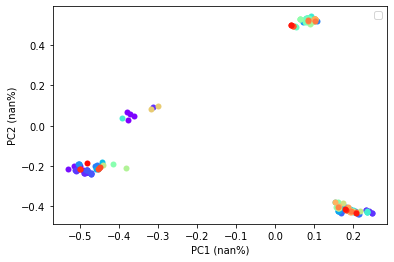

In [964]:
d = strain_diss.iloc[:300, :300]

strain_clust_palette = lib.plot.construct_ordered_pallete(range(clust.max()), cm='rainbow')

_ = lib.plot.ordination_plot(
    d,
    meta=clust.to_frame(name='clust'),
    colorby='clust',
    color_palette=strain_clust_palette,
    ordin=lib.plot.nmds_ordination,
    ordin_kws=dict(is_dmat=True),
    scatter_kws=dict(lw=0),
)

plt.legend([])

In [ ]:
# TODO: Dereplicate reference strains at some dissimilarity threshold

In [17]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances

g = gtpro_ref_102506

# x = pairwise_distances(g.values.T, metric='correlation', n_jobs=100)
# ref_position_diss = (1 - )**2
# ref_position_diss = pd.DataFrame(ref_position_diss, index=g.position.to_series(), columns=g.position.to_series())

In [25]:
position_meta_102506.groupby('contig').apply(len).sort_values(ascending=False).head()

contig
QFSG01000021    4749
QFSG01000226    4448
QFSG01000023    3949
QFSG01000010    3933
QFSG01000092    3900
dtype: int64

In [56]:
ld = {}
for contig, pos in position_meta_102506.groupby('contig'):
    print(contig)
    g = gtpro_ref_102506.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

QFSG01000004
QFSG01000008
QFSG01000010
QFSG01000013
QFSG01000021
QFSG01000023
QFSG01000024
QFSG01000025
QFSG01000026
QFSG01000028
QFSG01000030
QFSG01000031
QFSG01000032
QFSG01000036
QFSG01000039
QFSG01000040
QFSG01000046
QFSG01000050
QFSG01000051
QFSG01000052
QFSG01000059
QFSG01000060
QFSG01000064
QFSG01000065
QFSG01000066
QFSG01000067
QFSG01000074
QFSG01000075
QFSG01000076
QFSG01000077
QFSG01000078
QFSG01000086
QFSG01000087
QFSG01000088
QFSG01000091
QFSG01000092
QFSG01000093
QFSG01000094
QFSG01000096
QFSG01000099
QFSG01000100
QFSG01000105
QFSG01000109
QFSG01000114
QFSG01000116
QFSG01000118
QFSG01000119
QFSG01000130
QFSG01000138
QFSG01000140
QFSG01000142
QFSG01000150
QFSG01000163
QFSG01000166
QFSG01000167
QFSG01000169
QFSG01000172
QFSG01000194
QFSG01000196
QFSG01000197
QFSG01000198
QFSG01000200
QFSG01000203
QFSG01000217
QFSG01000226
QFSG01000231
QFSG01000232
QFSG01000235
QFSG01000250
QFSG01000251
QFSG01000260
QFSG01000263
QFSG01000267
QFSG01000294
QFSG01000298
QFSG01000310
QFSG01000325

SpearmanrResult(correlation=-0.08897163042636891, pvalue=0.0)


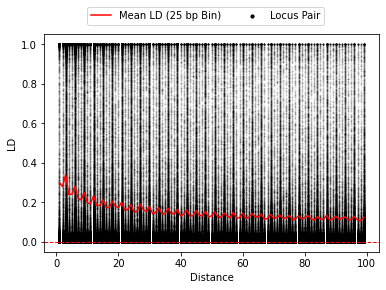

In [84]:
stepsize = 1
right = 100

d = ld[ld.x < right]

bins = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()
    
plt.scatter(
    x='x',
    y='r2',
    data=d,
    s=1,
    alpha=0.05,
    color='black',
    label='__nolegend__',
)
plt.scatter([], [], s=10, color='black', label='Locus Pair')
plt.plot(pd.Series(bins), color='red', label='Mean LD (25 bp Bin)')
plt.axhline(0, lw=1, color='red', linestyle='--')
plt.ylabel(r"LD")
plt.xlabel("Distance")
plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)

print(sp.stats.spearmanr(d['x'], d['r2']))